# Making Graphs for the Path of a Single Simulant

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from vivarium import InteractiveContext, Artifact

from datetime import datetime, timedelta
from pathlib import Path
import itertools
import matplotlib.pyplot as plt
import ipywidgets
import pandas as pd, numpy as np
pd.set_option('display.max_rows', 100)

import numpy as np
import researchpy as rp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

### Create interactive sim data 
#### Note: I have saved an old version of this data, you can choose to skip this step and just load the dataset below

Limit this to people of more interest (older) and do a small population for a long time since we aren't looking for population level information 

In [2]:
path = Path('/ihme/homes/lutzes/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')
path

PosixPath('/ihme/homes/lutzes/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')

In [3]:
sim = InteractiveContext(Path(path), setup=False)
sim.configuration.update({
                          'population':
                              {'population_size': 100,
                               'age_start': 50,
                              },
                          'time':
                              {'start':
                                  {'year': 2021
                                  }
                              },
                          'input_data':
                              {'input_draw_number': 829
                              }
                          }
                        )
sim.setup()

2023-08-04 06:47:29.361 | INFO     | simulation_1-artifact_manager:66 - Running simulation from artifact located at /mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf.
2023-08-04 06:47:29.363 | INFO     | simulation_1-artifact_manager:67 - Artifact base filter terms are ['draw == 829'].
2023-08-04 06:47:29.366 | INFO     | simulation_1-artifact_manager:68 - Artifact additional filter terms are None.


In [4]:
sim.configuration.polypill

exposure:
    model_override: 1
        source: /ihme/homes/lutzes/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml
    component_configs: data
        source: risk.risk_factor.polypill
rebinned_exposed:
    component_configs: []
        source: risk.risk_factor.polypill
category_thresholds:
    component_configs: []
        source: risk.risk_factor.polypill

In [5]:
sim.configuration.polypill_scale_up.value.start

0

In [4]:
pop0 = sim.get_population()
#pop0.head()

In [5]:
#sim.list_values()

data1 = pd.concat([pop0,
                   sim.get_value('outreach.exposure')(pop0.index),
                   sim.get_value('lifestyle.exposure')(pop0.index),
                   sim.get_value('polypill.exposure')(pop0.index),
                  ], axis=1)
data1.head()

In [6]:
sim_data = pd.DataFrame()
for step in list(range(0,240)):
    sim.step()
    pop_t = sim.get_population()
    data_t = pd.concat([pop_t, 
                   #sim.get_value('outreach.exposure')(pop0.index),
                   #sim.get_value('lifestyle.exposure')(pop0.index),
                   #sim.get_value('polypill.exposure')(pop0.index),                       
                      ], axis=1)
    data_t['step'] = step
    sim_data = pd.concat([sim_data, data_t])
    print(step)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239


In [23]:
sim_data['polypill'].unique()

array(['cat1'], dtype=object)

In [ ]:
# Lifestyle, polypill and outreach are the correct columns 
# Lifestyle will be a date or NaN 
# Polypill and outreach cat2 is not on it and cat1 is on it 

In [5]:
pop0 = sim.get_population()
pop0.head()

tracked        age location entrance_time exit_time     sex  alive  \
0     True  67.270690  Alabama    2020-12-04       NaT  Female  alive   
1     True  61.520269  Alabama    2020-12-04       NaT    Male  alive   
2     True  68.023296  Alabama    2020-12-04       NaT  Female  alive   
3     True  55.476363  Alabama    2020-12-04       NaT    Male  alive   
4     True  54.563836  Alabama    2020-12-04       NaT  Female  alive   

   years_of_life_lost cause_of_death  years_lived_with_disability  ...  \
0                 0.0       not_dead                          0.0  ...   
1                 0.0       not_dead                          0.0  ...   
2                 0.0       not_dead                          0.0  ...   
3                 0.0       not_dead                          0.0  ...   
4                 0.0       not_dead                          0.0  ...   

                sbp_medication polypill  sbp_multiplier  outreach  \
0  one_drug_half_dose_efficacy     cat2           1.051      cat2   
1  one_drug_half_dose_efficacy     cat2           1.051      cat2   
2  two_drug_half_dose_efficacy     cat2           1.120      cat2   
3  one_drug_half_dose_efficacy     cat2           1.000      cat2   
4                 no_treatment     cat2           1.000      cat2   

   sbp_medication_adherence  ldlc_multiplier lifestyle_adherence  \
0                      cat3            1.000                True   
1                      cat3            1.362                True   
2                      cat3            1.362                True   
3                      cat1            1.000                True   
4                      cat3            1.000                True   

  scheduled_date  visit_type            last_fpg_test_date  
0            NaT        none                           NaT  
1            NaT        none 2018-10-16 07:11:15.929783776  
2            NaT        none 2018-06-26 18:38:33.275235712  
3            NaT        none 2019-10-06 08:55:58.363978600  
4            NaT        none 2019-12-17 19:48:00.406137180  

[5 rows x 62 columns]

In [5]:
#pop0.columns

In [15]:
sim_data = pd.DataFrame()
for step in list(range(0,100)):
    sim.step()
    pop_t = sim.get_population()
    data_t = pd.concat([pop_t],axis=1)
    data_t['step'] = step
    sim_data = pd.concat([sim_data, data_t])
    print(step)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [16]:
sim_data.head()

tracked        age entrance_time     sex exit_time  alive location  \
0     True  67.347350    2020-12-04  Female       NaT  alive  Alabama   
1     True  61.596929    2020-12-04    Male       NaT  alive  Alabama   
2     True  68.099956    2020-12-04  Female       NaT  alive  Alabama   
3     True  55.553023    2020-12-04    Male       NaT  alive  Alabama   
4     True  54.640496    2020-12-04  Female       NaT  alive  Alabama   

  cause_of_death  years_of_life_lost  years_lived_with_disability  ...  \
0       not_dead                 0.0                          0.0  ...   
1       not_dead                 0.0                          0.0  ...   
2       not_dead                 0.0                          0.0  ...   
3       not_dead                 0.0                          0.0  ...   
4       not_dead                 0.0                          0.0  ...   

    ldlc_medication lifestyle_adherence  outreach  ldlc_multiplier  \
0      no_treatment                True      cat2            1.000   
1  medium_intensity                True      cat2            1.362   
2  medium_intensity                True      cat2            1.362   
3      no_treatment                True      cat2            1.000   
4      no_treatment                True      cat2            1.000   

   sbp_multiplier  lifestyle                scheduled_date  \
0           1.051        NaT 2021-06-15 21:37:52.737139200   
1           1.051        NaT                           NaT   
2           1.000        NaT                           NaT   
3           1.000        NaT                           NaT   
4           1.000        NaT                           NaT   

             last_fpg_test_date  visit_type  step  
0 2018-01-17 21:14:56.646121744  background     0  
1 2018-10-16 07:11:15.929783776        none     0  
2 2018-06-26 18:38:33.275235712        none     0  
3 2019-10-06 08:55:58.363978600        none     0  
4 2019-12-17 19:48:00.406137180        none     0  

[5 rows x 63 columns]

In [7]:
sim_data.to_csv('/ihme/homes/lutzes/sim_graphs_100_steps_lifestyle_08042023.csv')

## Analyze Data and Set Up Columns for Graphing 

In [8]:
full_data = pd.read_csv('/ihme/homes/lutzes/sim_graphs_100_steps_lifestyle_08042023.csv')
full_data.head()

/tmp/ipykernel_634145/2451685243.py:1: DtypeWarning: Columns (31,49) have mixed types. Specify dtype option on import or set low_memory=False.
  full_data = pd.read_csv('/ihme/homes/lutzes/sim_graphs_100_steps_lifestyle_08042023.csv')


Unnamed: 0  tracked entrance_time  alive        age     sex exit_time  \
0           0     True    2020-12-04  alive  67.347350  Female       NaN   
1           1     True    2020-12-04  alive  61.596929    Male       NaN   
2           2     True    2020-12-04  alive  68.099956  Female       NaN   
3           3     True    2020-12-04  alive  55.553023    Male       NaN   
4           4     True    2020-12-04  alive  54.640496  Female       NaN   

  location  years_of_life_lost cause_of_death  ...  sbp_multiplier  \
0  Alabama                 0.0       not_dead  ...           1.051   
1  Alabama                 0.0       not_dead  ...           1.051   
2  Alabama                 0.0       not_dead  ...           1.120   
3  Alabama                 0.0       not_dead  ...           1.000   
4  Alabama                 0.0       not_dead  ...           1.000   

                sbp_medication polypill  lifestyle_adherence  \
0  one_drug_half_dose_efficacy     cat1                 True   
1  one_drug_half_dose_efficacy     cat1                 True   
2  two_drug_half_dose_efficacy     cat1                 True   
3  one_drug_half_dose_efficacy     cat1                 True   
4                 no_treatment     cat1                 True   

   sbp_medication_adherence  outreach                 scheduled_date  \
0                      cat3      cat1  2021-06-15 21:37:52.737139200   
1                      cat3      cat1                            NaN   
2                      cat3      cat1                            NaN   
3                      cat1      cat1                            NaN   
4                      cat3      cat1                            NaN   

   visit_type             last_fpg_test_date  step  
0  background  2018-01-17 21:14:56.646121744     0  
1        none  2018-10-16 07:11:15.929783776     0  
2        none  2018-06-26 18:38:33.275235712     0  
3        none  2019-10-06 08:55:58.363978600     0  
4        none                            NaN     0  

[5 rows x 64 columns]

In [9]:
test_data = full_data.loc[(full_data.age > 25)]
test_data['age_start'] = ((test_data.age/5).astype(int) * 5).astype(float)
test_data = test_data.rename(columns={'Unnamed: 0':'sim_id'})

In [10]:
event_data = test_data[['sim_id','exit_time','sex','alive','age_start','cause_of_death','years_of_life_lost','years_lived_with_disability','ischemic_stroke','ischemic_heart_disease_and_heart_failure','outreach','lifestyle','polypill','sbp_medication','sbp_medication_adherence','ldlc_medication','ldlc_medication_adherence','scheduled_date','visit_type','step']]
event_data.head()

sim_id exit_time     sex  alive  age_start cause_of_death  \
0       0       NaN  Female  alive       65.0       not_dead   
1       1       NaN    Male  alive       60.0       not_dead   
2       2       NaN  Female  alive       65.0       not_dead   
3       3       NaN    Male  alive       55.0       not_dead   
4       4       NaN  Female  alive       50.0       not_dead   

   years_of_life_lost  years_lived_with_disability  \
0                 0.0                          0.0   
1                 0.0                          0.0   
2                 0.0                          0.0   
3                 0.0                          0.0   
4                 0.0                          0.0   

                  ischemic_stroke  \
0  susceptible_to_ischemic_stroke   
1  susceptible_to_ischemic_stroke   
2  susceptible_to_ischemic_stroke   
3  susceptible_to_ischemic_stroke   
4  susceptible_to_ischemic_stroke   

            ischemic_heart_disease_and_heart_failure outreach lifestyle  \
0  susceptible_to_ischemic_heart_disease_and_hear...     cat1       NaN   
1  susceptible_to_ischemic_heart_disease_and_hear...     cat1       NaN   
2  susceptible_to_ischemic_heart_disease_and_hear...     cat1       NaN   
3  susceptible_to_ischemic_heart_disease_and_hear...     cat1       NaN   
4  susceptible_to_ischemic_heart_disease_and_hear...     cat1       NaN   

  polypill               sbp_medication sbp_medication_adherence  \
0     cat1  one_drug_half_dose_efficacy                     cat3   
1     cat1  one_drug_half_dose_efficacy                     cat3   
2     cat1  two_drug_half_dose_efficacy                     cat3   
3     cat1  one_drug_half_dose_efficacy                     cat1   
4     cat1                 no_treatment                     cat3   

    ldlc_medication ldlc_medication_adherence                 scheduled_date  \
0      no_treatment                      cat3  2021-06-15 21:37:52.737139200   
1  medium_intensity                      cat3                            NaN   
2  medium_intensity                      cat3                            NaN   
3      no_treatment                      cat3                            NaN   
4      no_treatment                      cat2                            NaN   

   visit_type  step  
0  background     0  
1        none     0  
2        none     0  
3        none     0  
4        none     0

In [11]:
event_data.lifestyle.unique()

array([nan, '2021-03-26', '2021-04-23', '2021-06-18', '2021-07-16',
       '2021-08-13', '2021-09-10', '2021-12-03', '2021-12-31',
       '2022-02-25', '2022-10-07', '2022-12-30', '2023-02-24',
       '2023-05-19', '2024-06-14', '2025-06-13', '2027-08-06',
       '2027-09-03', '2028-02-18', '2028-06-09', '2029-03-16',
       '2031-01-17', '2031-06-06', '2033-12-16', '2036-01-11',
       '2036-06-27'], dtype=object)

In [5]:
#event_data.loc[((event_data.ischemic_heart_disease_and_heart_failure != 'susceptible_to_ischemic_heart_disease_and_heart_failure')) & (event_data.step > 10)]

In [14]:
event_data = event_data.sort_values(['sim_id','step'])
event_data['ldl_change'] = np.where(event_data['ldlc_medication'] != event_data['ldlc_medication'].shift(1), event_data['step'],0)
event_data['sbp_change'] = np.where(event_data['sbp_medication'] != event_data['sbp_medication'].shift(1), event_data['step'],0)
event_data['lifestyle_start'] = np.where(event_data['lifestyle'] != event_data['lifestyle'].shift(1), event_data['step'],0)
event_data.loc[event_data.sim_id == 19]

sim_id   exit_time     sex  alive  age_start  \
19         19         NaN  Female  alive       70.0   
119        19         NaN  Female  alive       70.0   
219        19         NaN  Female  alive       70.0   
319        19         NaN  Female  alive       70.0   
419        19         NaN  Female  alive       70.0   
...       ...         ...     ...    ...        ...   
23519      19  2033-08-26  Female   dead       85.0   
23619      19  2033-08-26  Female   dead       85.0   
23719      19  2033-08-26  Female   dead       85.0   
23819      19  2033-08-26  Female   dead       85.0   
23919      19  2033-08-26  Female   dead       85.0   

                                  cause_of_death  years_of_life_lost  \
19                                      not_dead            0.000000   
119                                     not_dead            0.000000   
219                                     not_dead            0.000000   
319                                     not_dead            0.000000   
419                                     not_dead            0.000000   
...                                          ...                 ...   
23519  heart_failure_from_ischemic_heart_disease            9.145587   
23619  heart_failure_from_ischemic_heart_disease            9.145587   
23719  heart_failure_from_ischemic_heart_disease            9.145587   
23819  heart_failure_from_ischemic_heart_disease            9.145587   
23919  heart_failure_from_ischemic_heart_disease            9.145587   

       years_lived_with_disability                 ischemic_stroke  \
19                        0.000000  susceptible_to_ischemic_stroke   
119                       0.000000  susceptible_to_ischemic_stroke   
219                       0.000000  susceptible_to_ischemic_stroke   
319                       0.000000  susceptible_to_ischemic_stroke   
419                       0.000000  susceptible_to_ischemic_stroke   
...                            ...                             ...   
23519                     0.239734  susceptible_to_ischemic_stroke   
23619                     0.239734  susceptible_to_ischemic_stroke   
23719                     0.239734  susceptible_to_ischemic_stroke   
23819                     0.239734  susceptible_to_ischemic_stroke   
23919                     0.239734  susceptible_to_ischemic_stroke   

                ischemic_heart_disease_and_heart_failure  ...  \
19     susceptible_to_ischemic_heart_disease_and_hear...  ...   
119    susceptible_to_ischemic_heart_disease_and_hear...  ...   
219    susceptible_to_ischemic_heart_disease_and_hear...  ...   
319    susceptible_to_ischemic_heart_disease_and_hear...  ...   
419    susceptible_to_ischemic_heart_disease_and_hear...  ...   
...                                                  ...  ...   
23519          heart_failure_from_ischemic_heart_disease  ...   
23619          heart_failure_from_ischemic_heart_disease  ...   
23719          heart_failure_from_ischemic_heart_disease  ...   
23819          heart_failure_from_ischemic_heart_disease  ...   
23919          heart_failure_from_ischemic_heart_disease  ...   

                    sbp_medication sbp_medication_adherence   ldlc_medication  \
19     one_drug_half_dose_efficacy                     cat3  medium_intensity   
119    one_drug_half_dose_efficacy                     cat3  medium_intensity   
219    one_drug_half_dose_efficacy                     cat3  medium_intensity   
319    one_drug_half_dose_efficacy                     cat3  medium_intensity   
419    one_drug_half_dose_efficacy                     cat3  medium_intensity   
...                            ...                      ...               ...   
23519  one_drug_half_dose_efficacy                     cat3     high_with_eze   
23619  one_drug_half_dose_efficacy                     cat3     high_with_eze   
23719  one_drug_half_dose_efficacy                     cat3     high_with_eze   
23819  one_drug_half_dose_efficacy               

In [24]:
#event_data.loc[event_data.ischemic_heart_disease_and_heart_failure=='acute_myocardial_infarction']

## Creating the Graphs

In [46]:
single_sim = event_data.loc[(event_data['sim_id']==19)]
#single_sim.lifestyle #.head()

In [17]:
def visits(single_sim):
    background = single_sim.step.loc[(single_sim.visit_type=='background') & (single_sim.alive=='alive')]
    background_y = [5] * len(background)
    scheduled = single_sim.step.loc[(single_sim.visit_type=='scheduled') & (single_sim.alive=='alive')]
    scheduled_y = [5] * len(scheduled)
    emergency = single_sim.step.loc[(single_sim.visit_type=='emergency') & (single_sim.alive=='alive')]
    emergency_y = [5] * len(emergency)
    return background, background_y, scheduled, scheduled_y, emergency, emergency_y

In [53]:
def lifestyle_func(single_sim):
    lifestyle = single_sim.step.loc[single_sim.lifestyle.notna()]
    if len(lifestyle > 0): 
        lifestyle = lifestyle.iloc[0]
        lifestyle_y = [3]
    else:
        lifestyle_y = []
    return lifestyle, lifestyle_y

In [19]:
def meds(single_sim):
    ldl = single_sim.ldl_change.loc[single_sim.ldl_change!=0]
    ldl_y = [4] * len(ldl)
    sbp = single_sim.sbp_change.loc[single_sim.sbp_change!=0]
    sbp_y = [4] * len(sbp)
    return ldl, ldl_y, sbp, sbp_y

In [20]:
def health_events(single_sim): 
    died = single_sim.step.loc[single_sim.alive=='dead']
    if len(died > 0): 
        died = died.iloc[0]
        died_y = [2]
    else: 
        died_y = []
    MI = single_sim.step.loc[single_sim.ischemic_heart_disease_and_heart_failure=='acute_myocardial_infarction']
    MI = MI[1:].values.tolist()
    MI[:] = [x for x in MI if x <= died]
    MI_y = [2] * len(MI)
    HF = single_sim.step.loc[(single_sim.ischemic_heart_disease_and_heart_failure=='heart_failure_residual') | (single_sim.ischemic_heart_disease_and_heart_failure=='heart_failure_from_ischemic_heart_disease')]
    if len(HF > 0): 
        HF = HF.iloc[0]
        HF_y = [2]
    else: 
        HF_y = []
    stroke = single_sim.step.loc[single_sim.ischemic_stroke=='acute_ischemic_stroke']
    stroke_y = [2] * len(stroke)
    if (MI or len(stroke > 0)):
        died = died + 1
    return died, died_y, MI, MI_y, HF, HF_y, stroke, stroke_y

/tmp/ipykernel_634145/1658679036.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


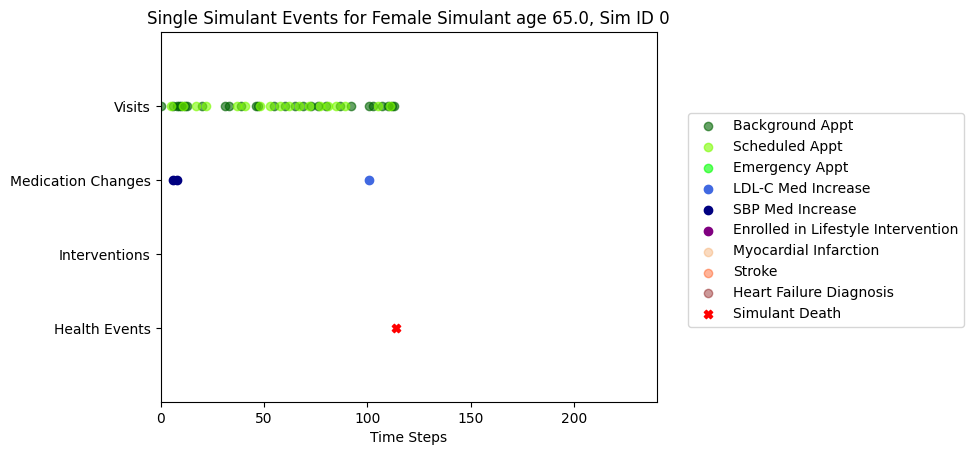

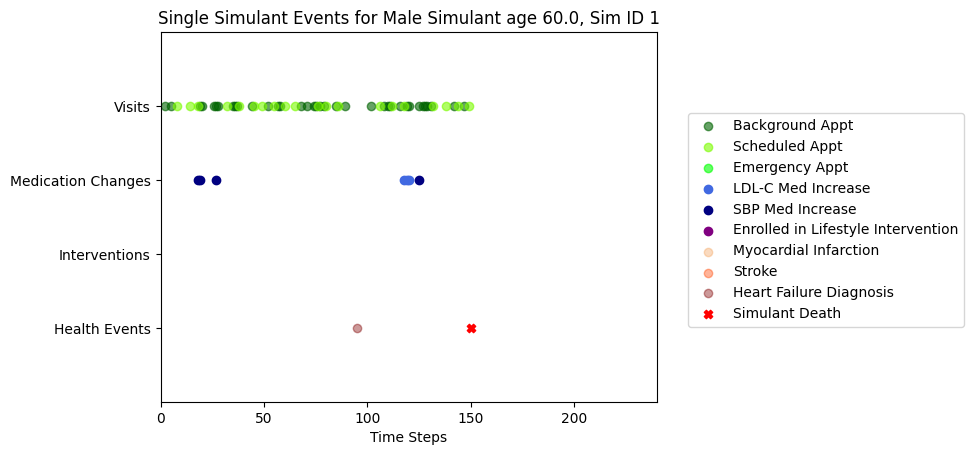

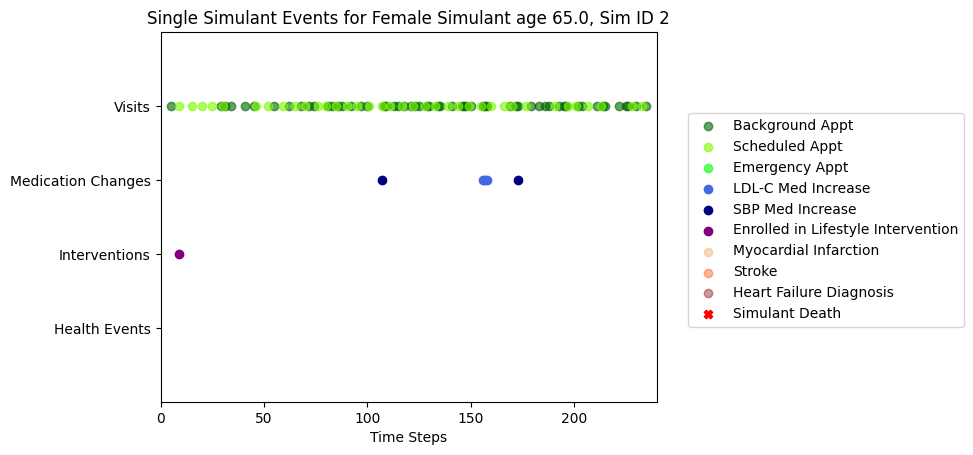

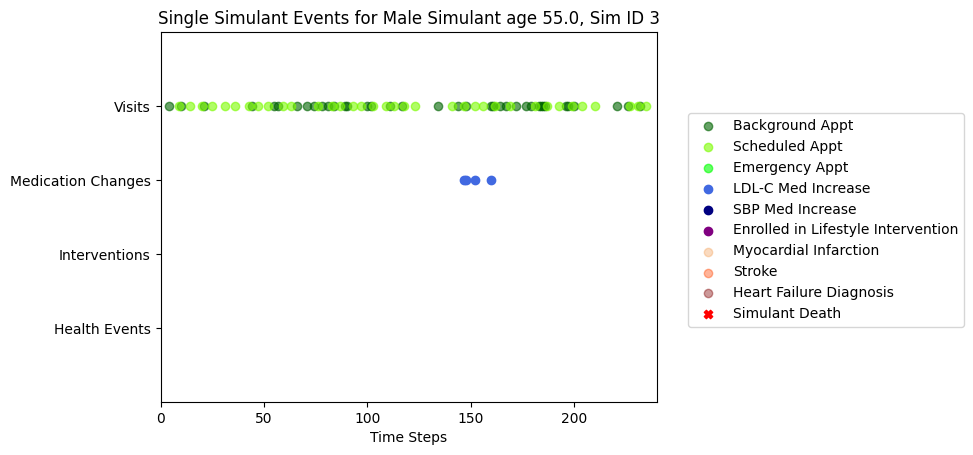

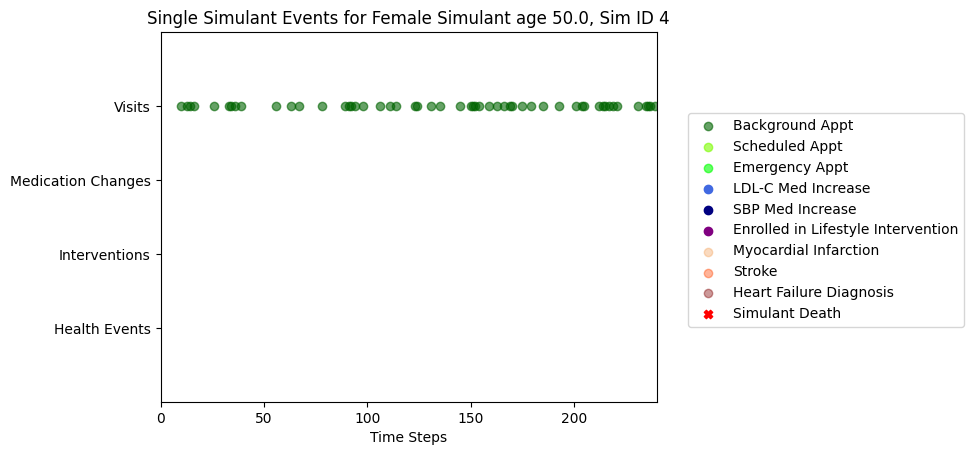

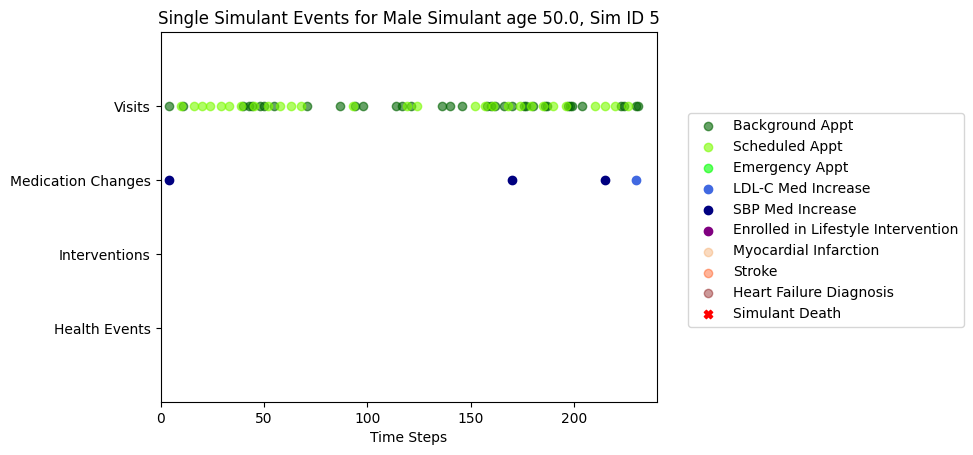

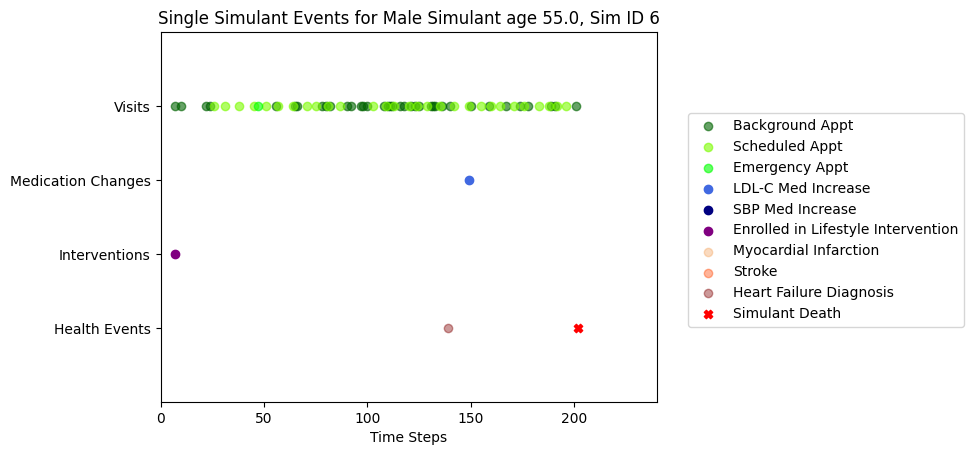

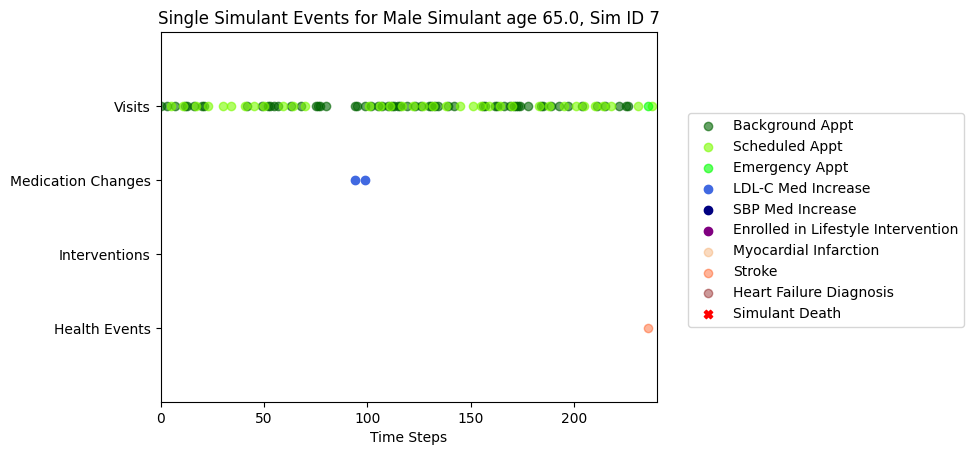

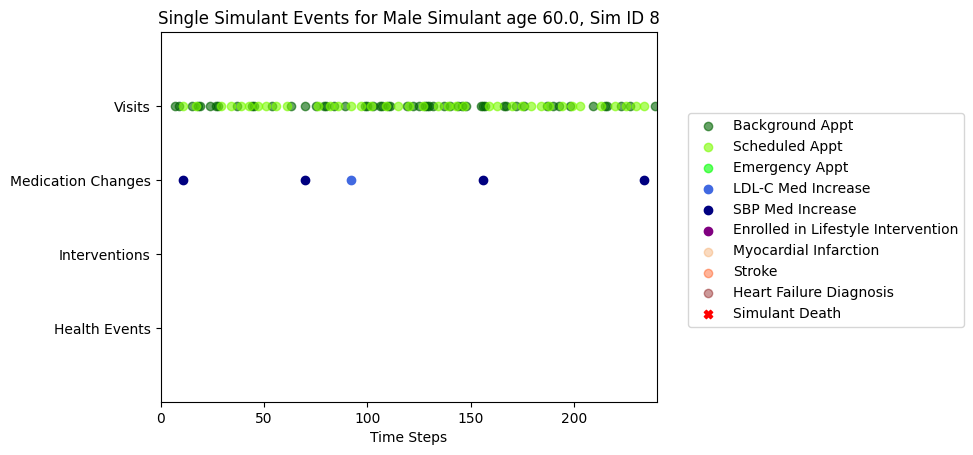

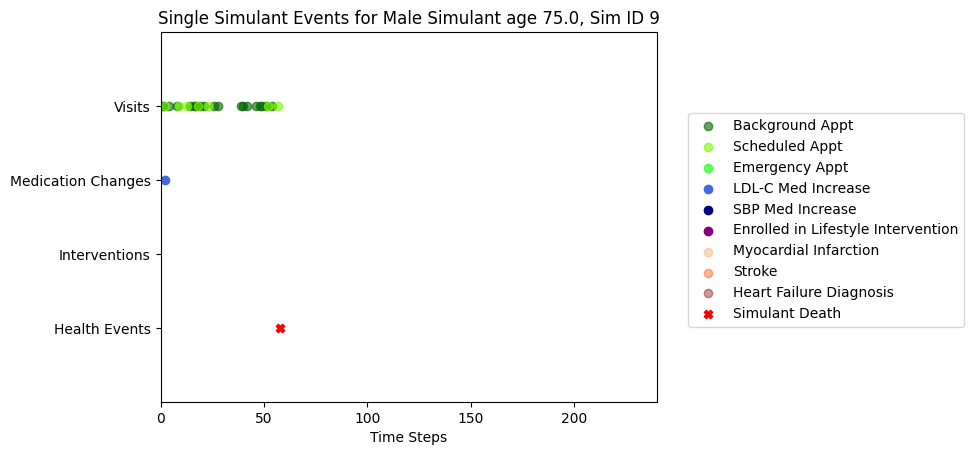

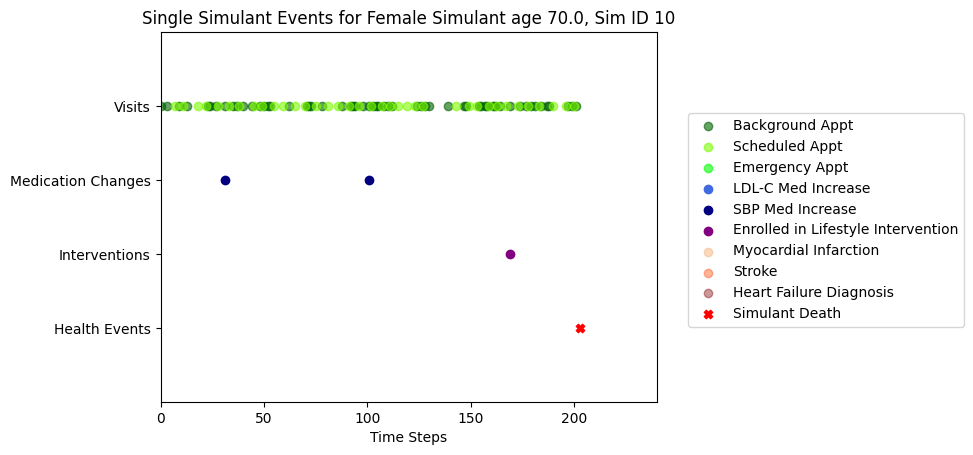

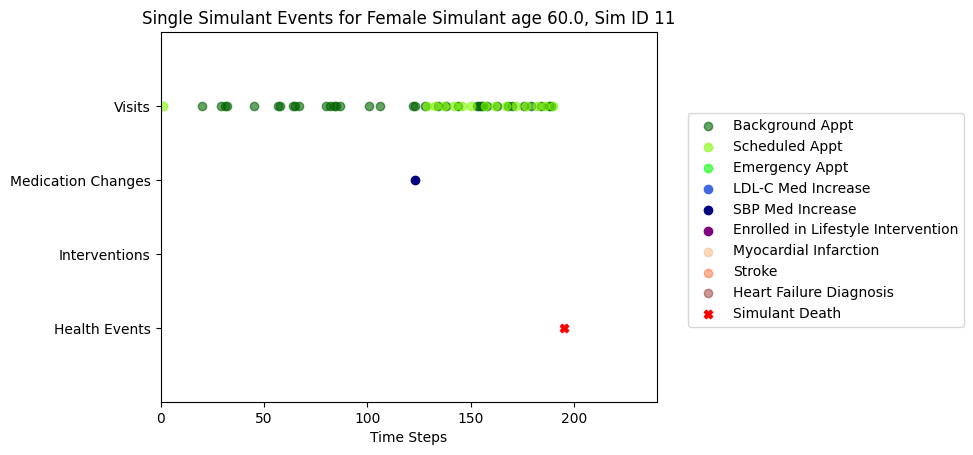

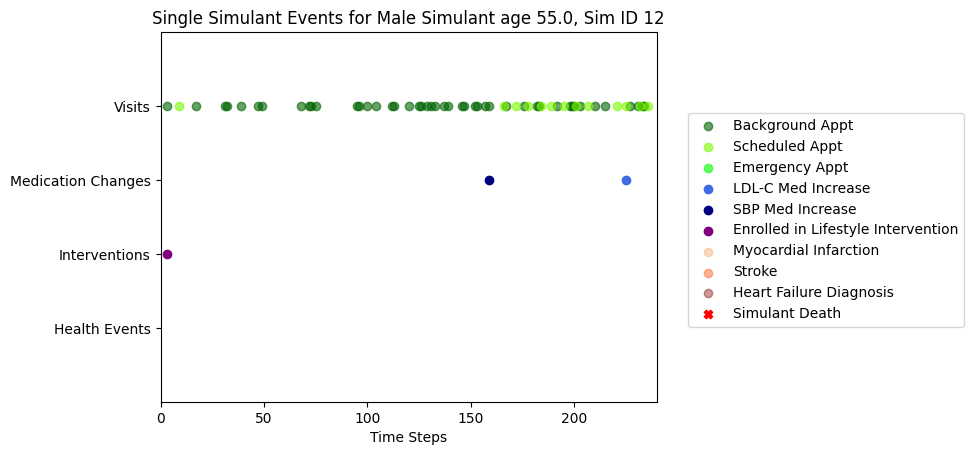

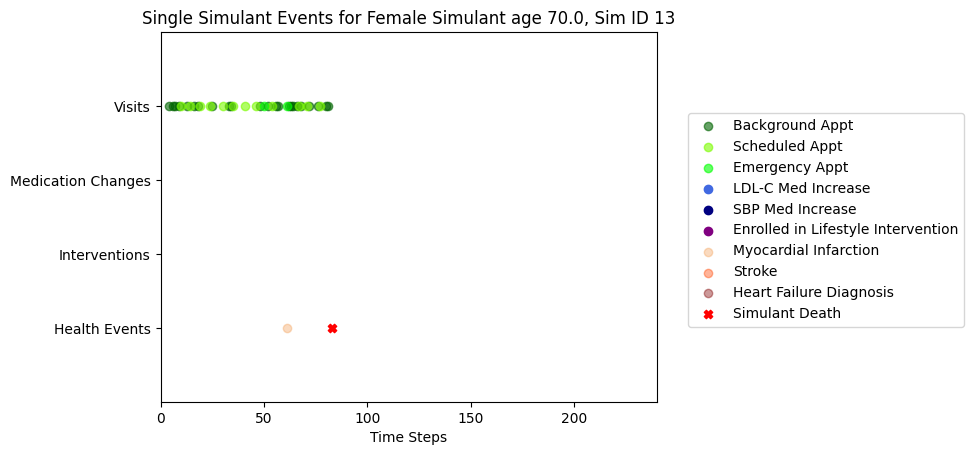

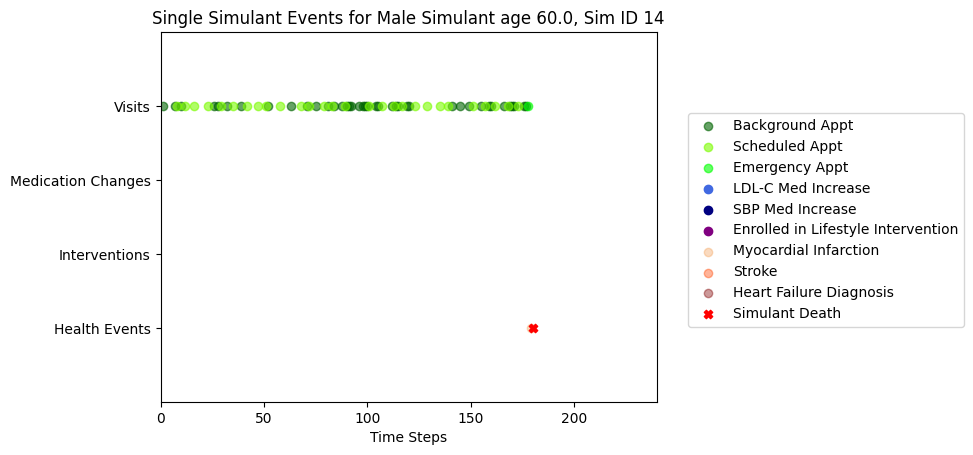

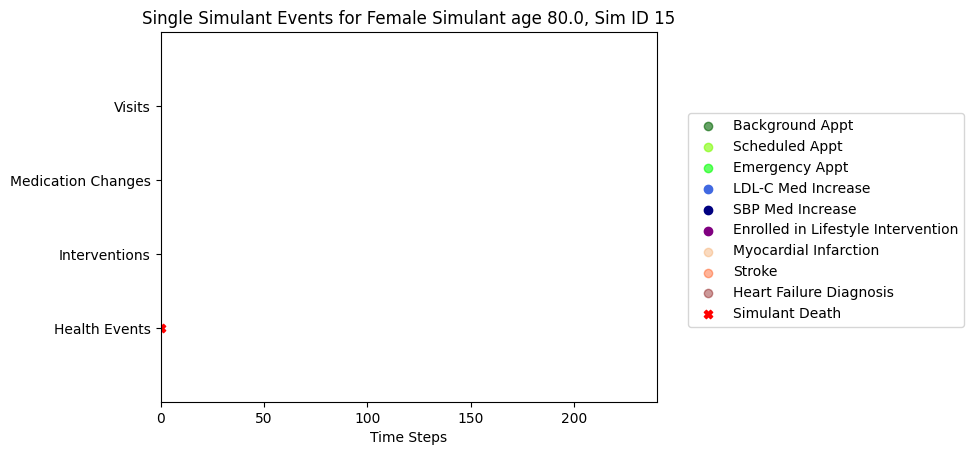

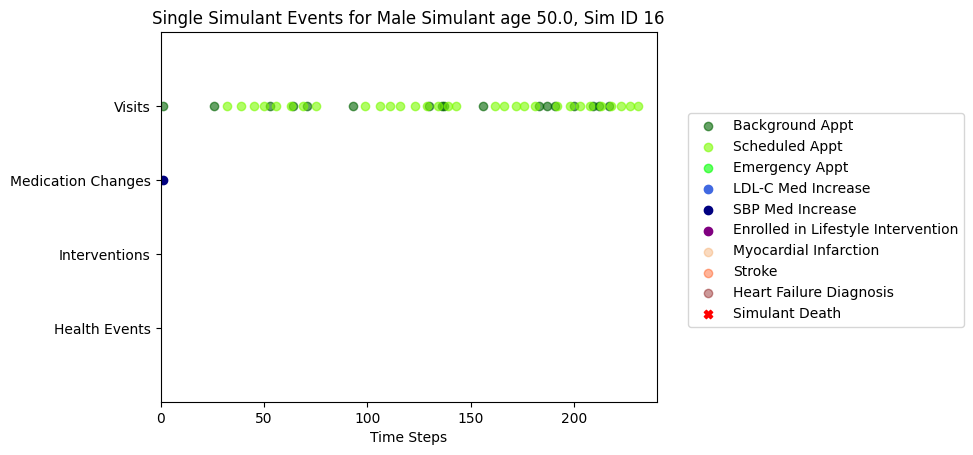

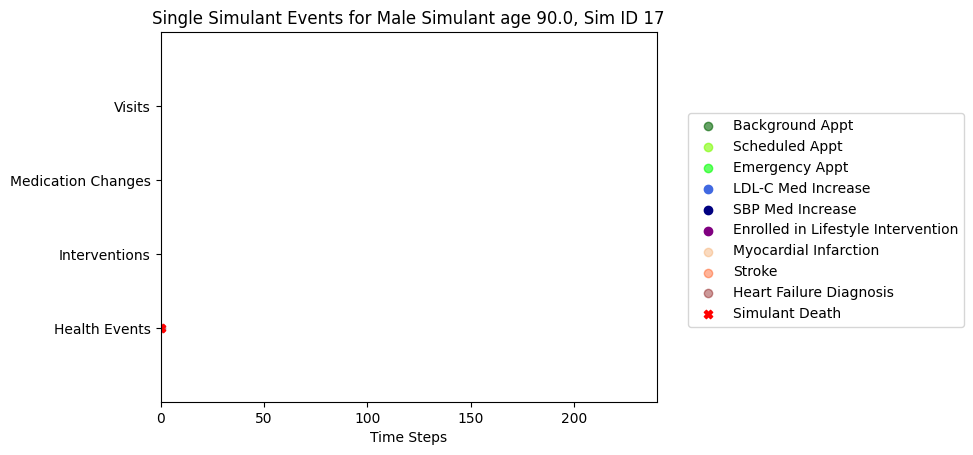

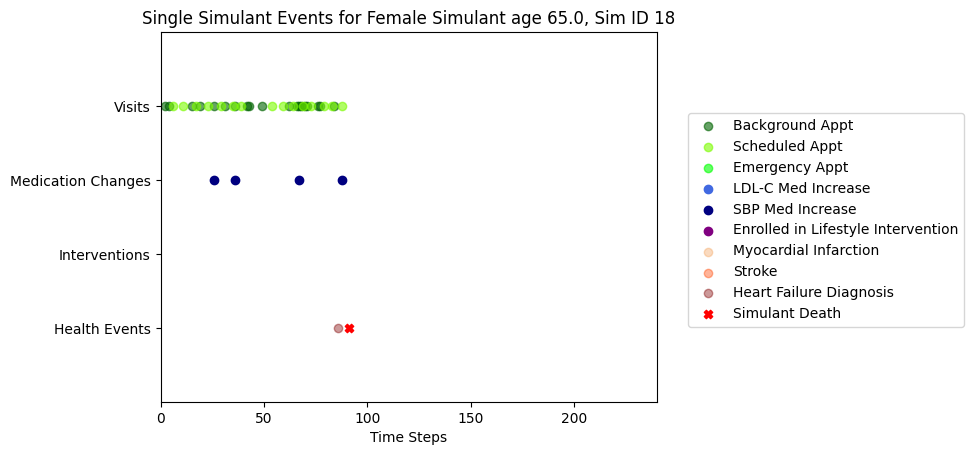

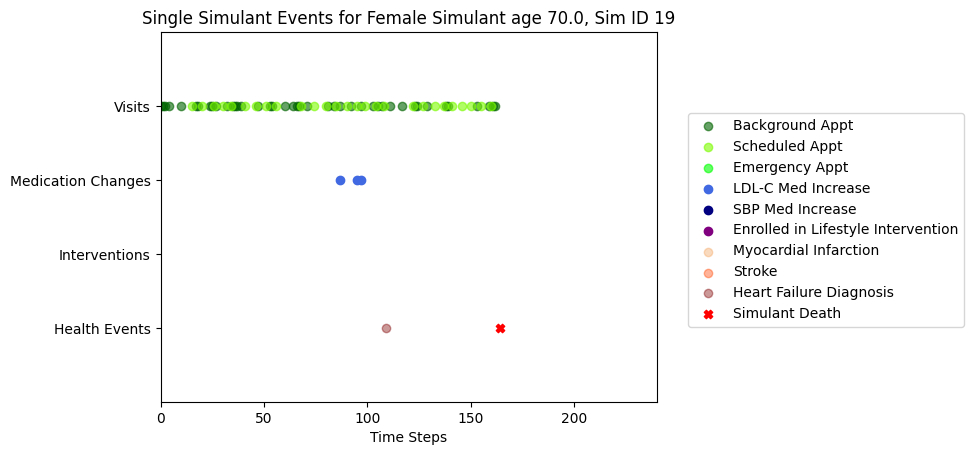

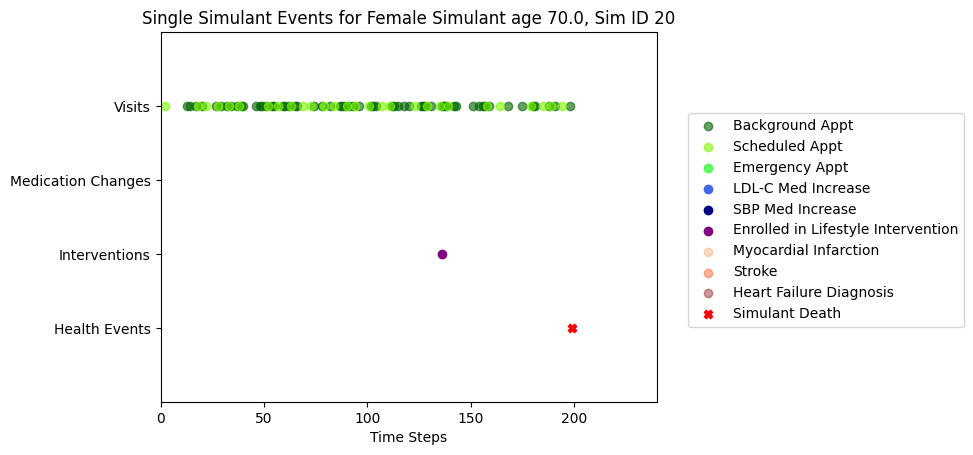

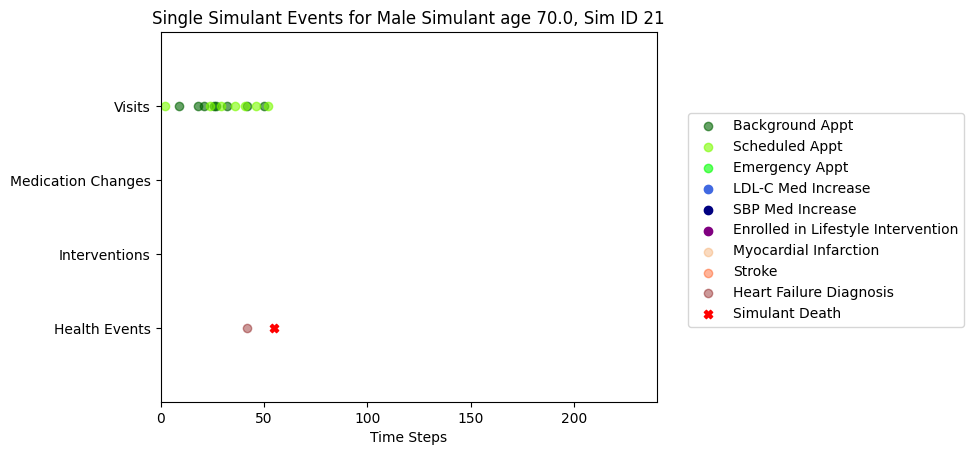

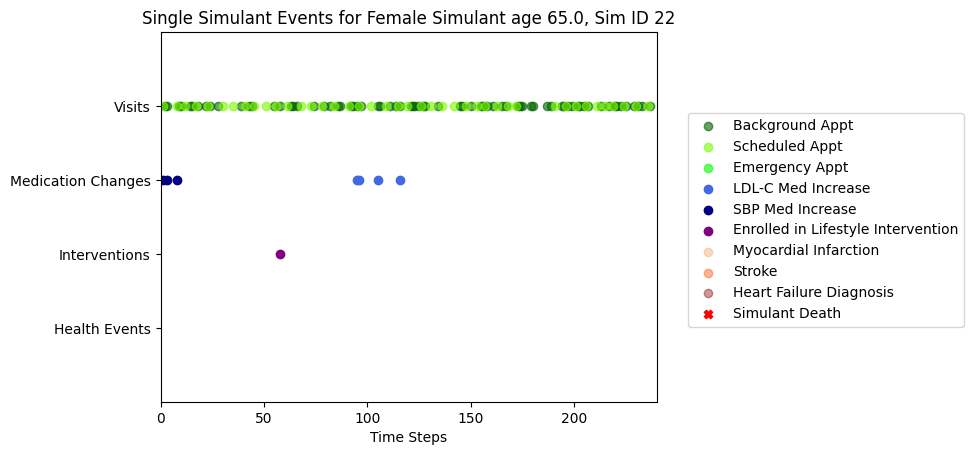

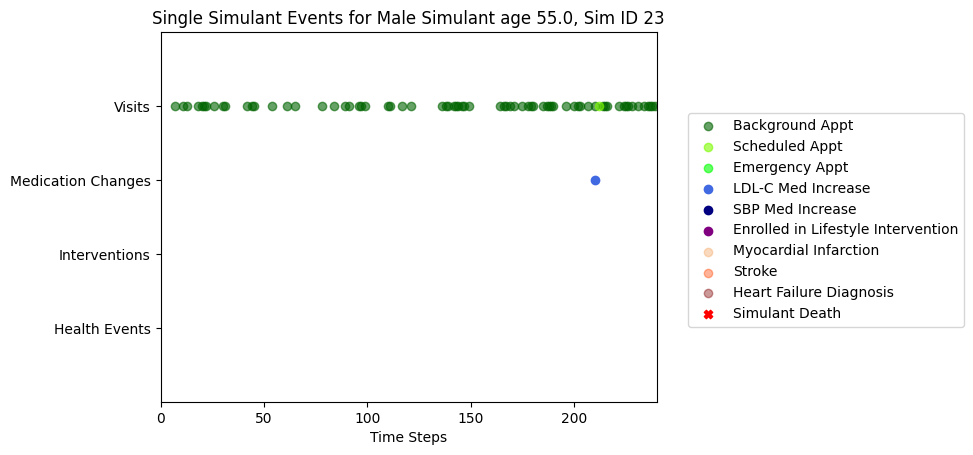

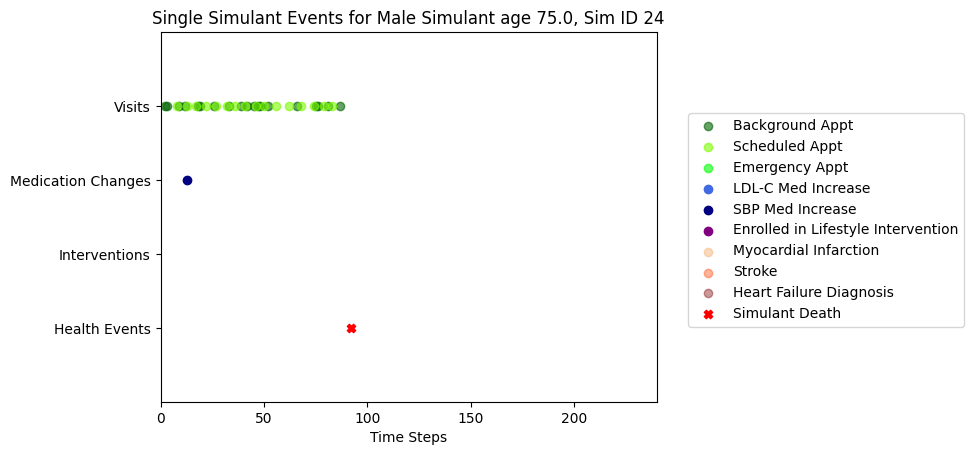

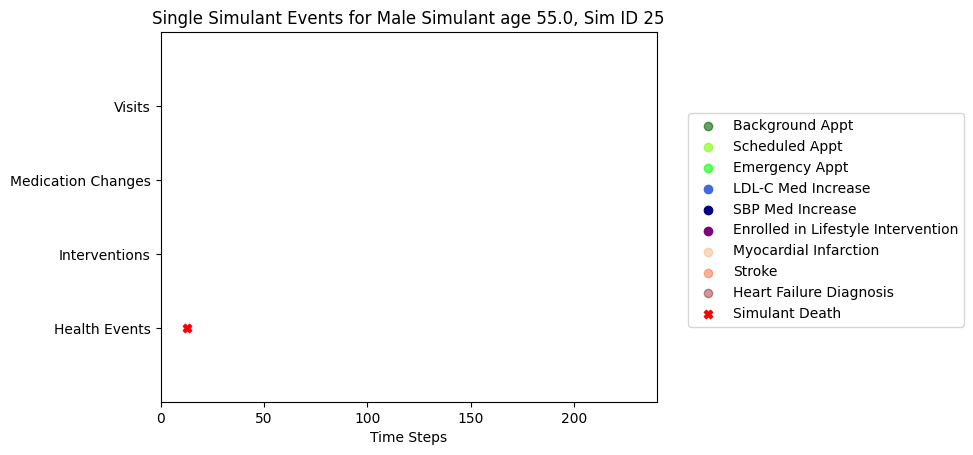

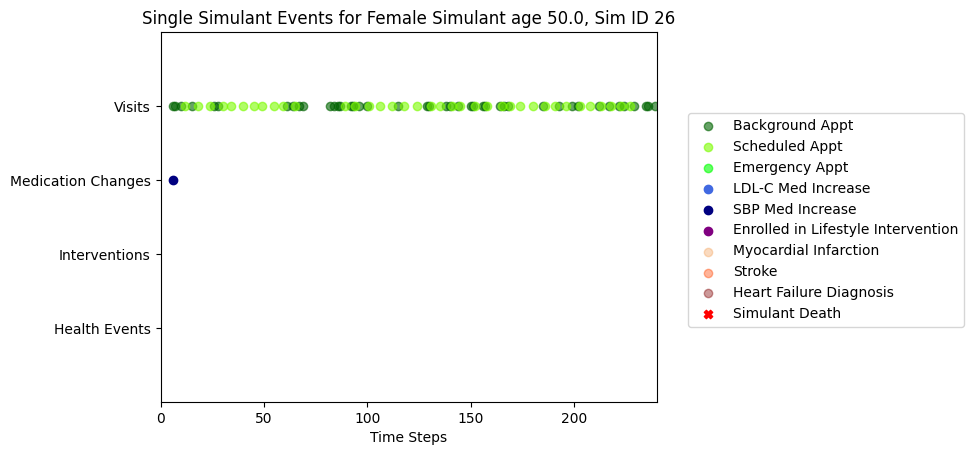

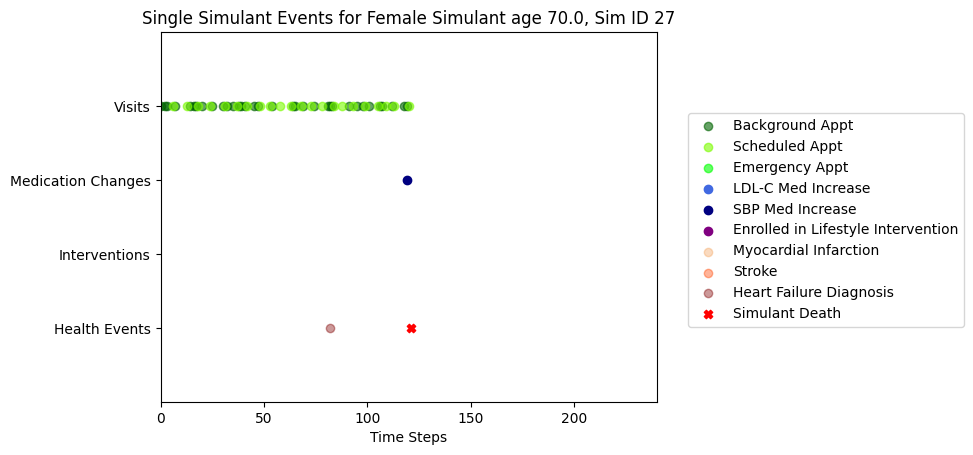

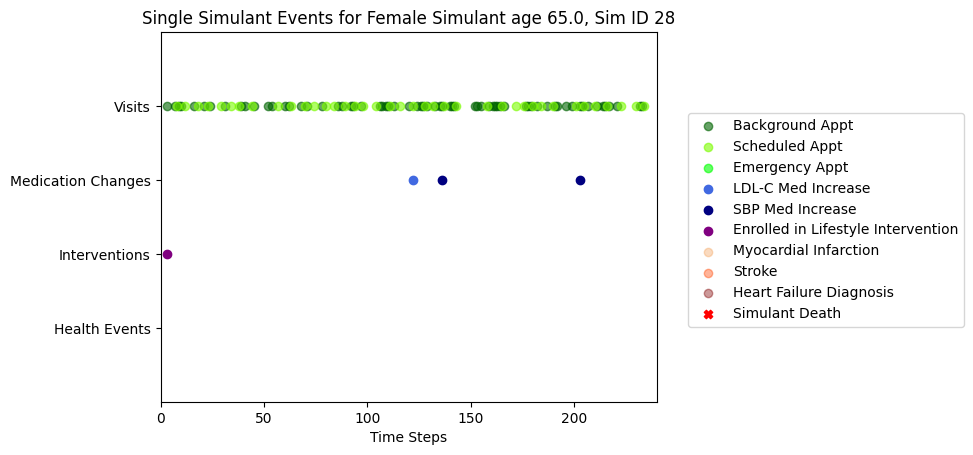

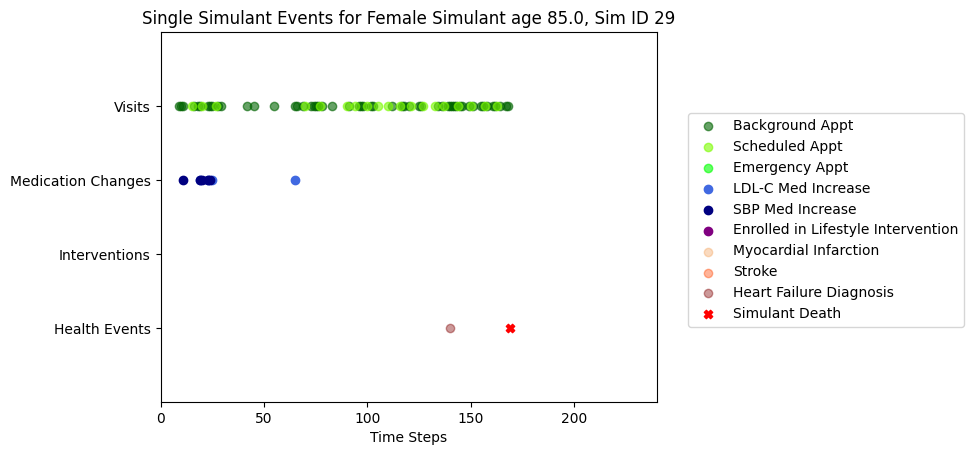

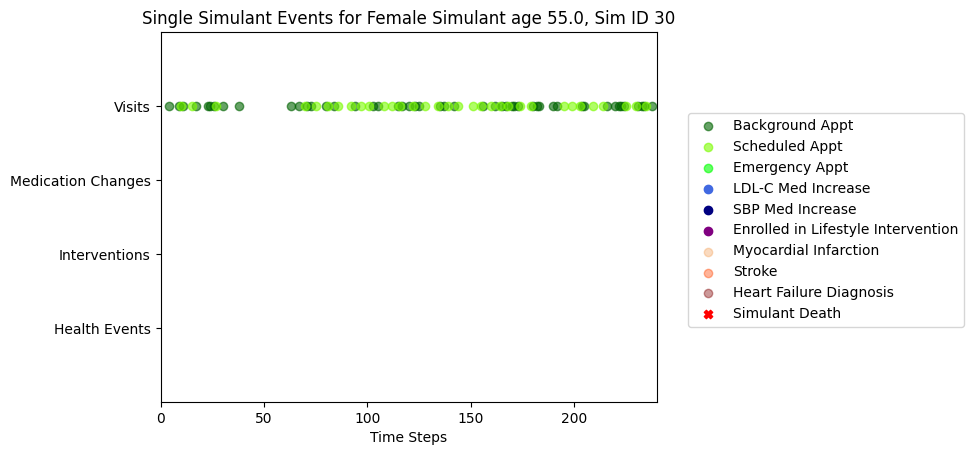

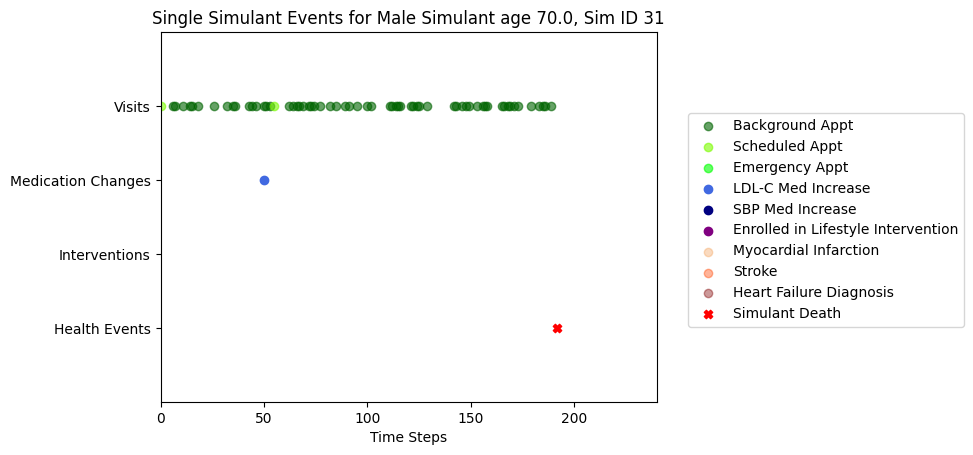

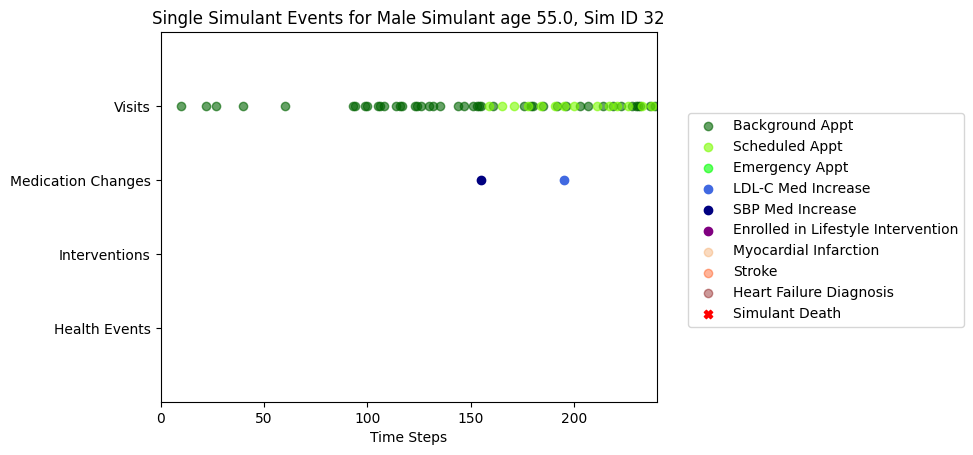

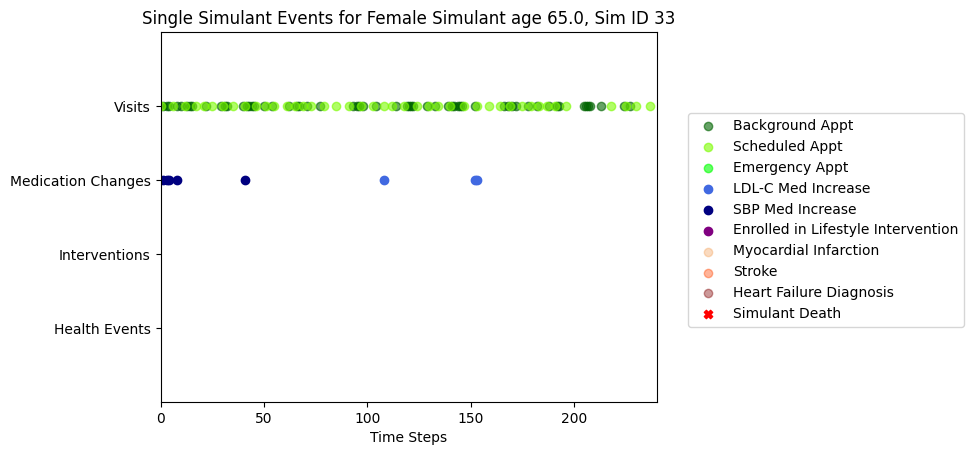

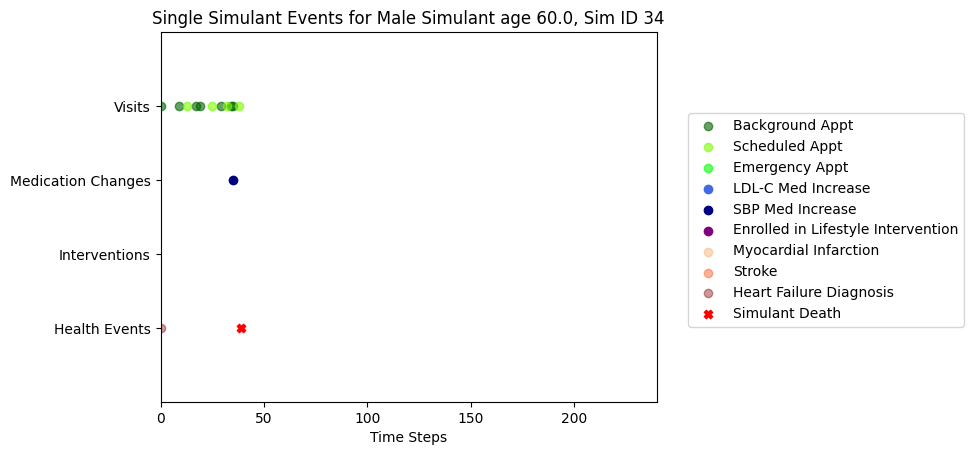

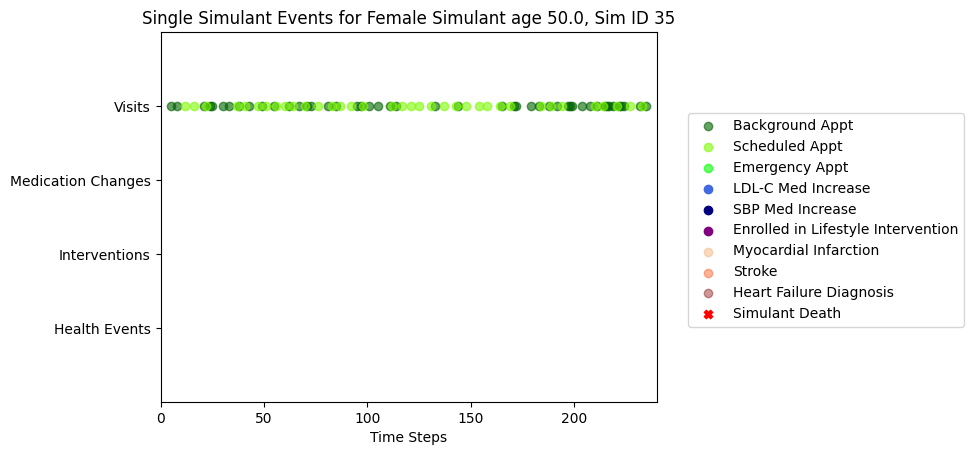

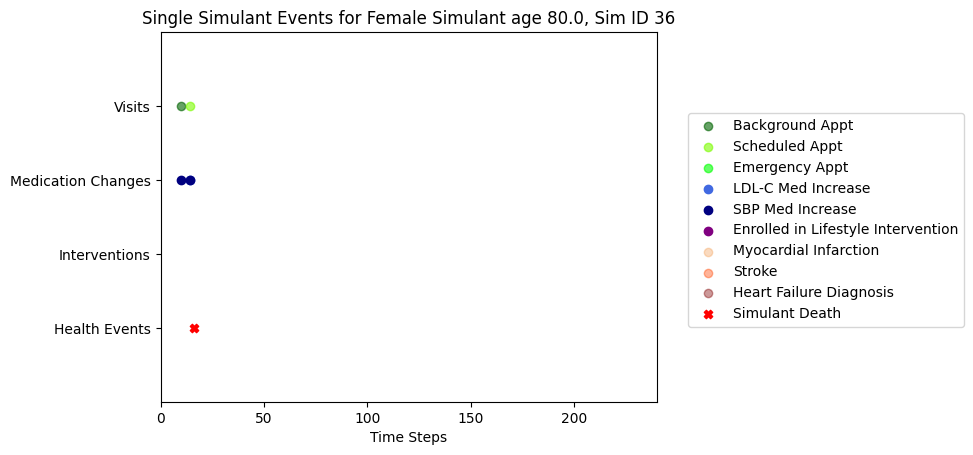

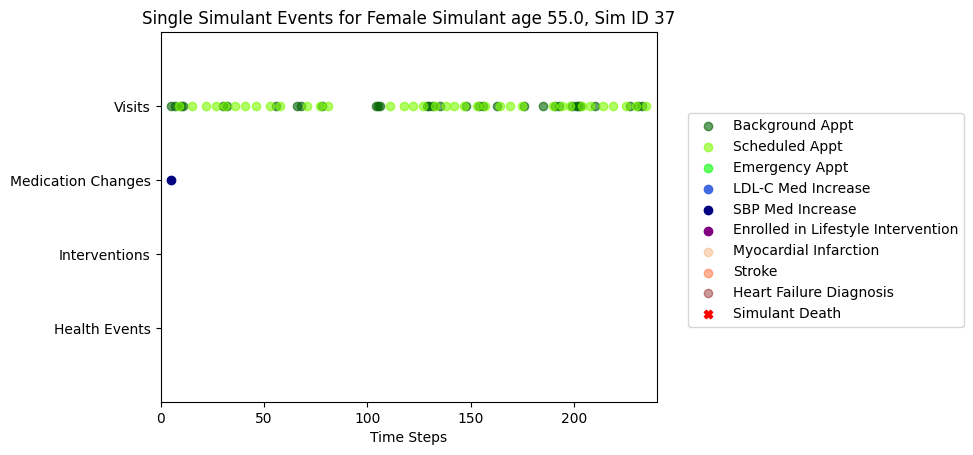

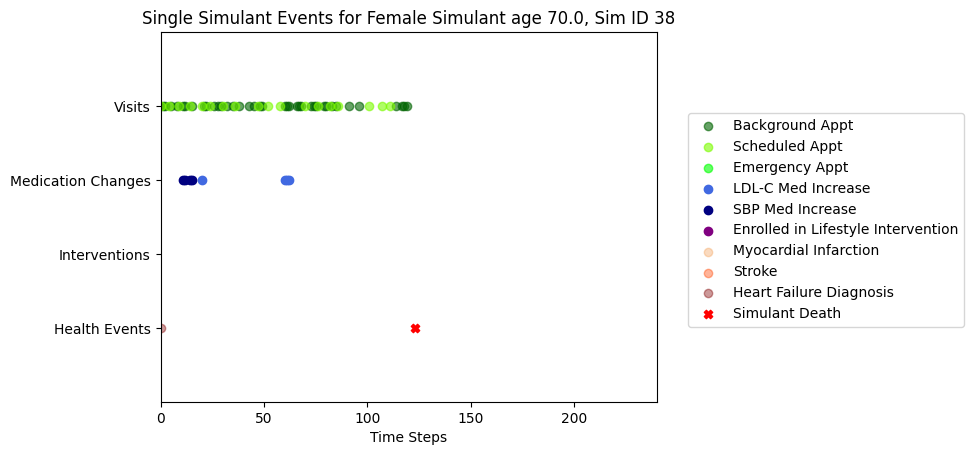

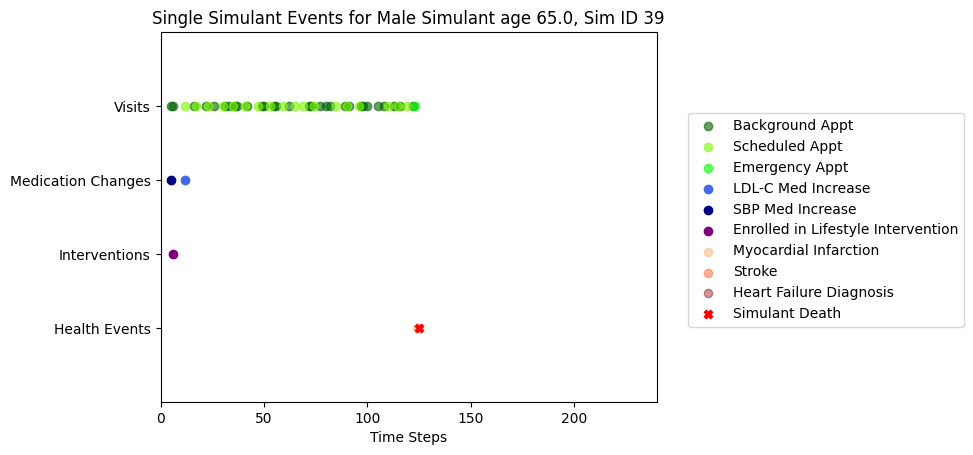

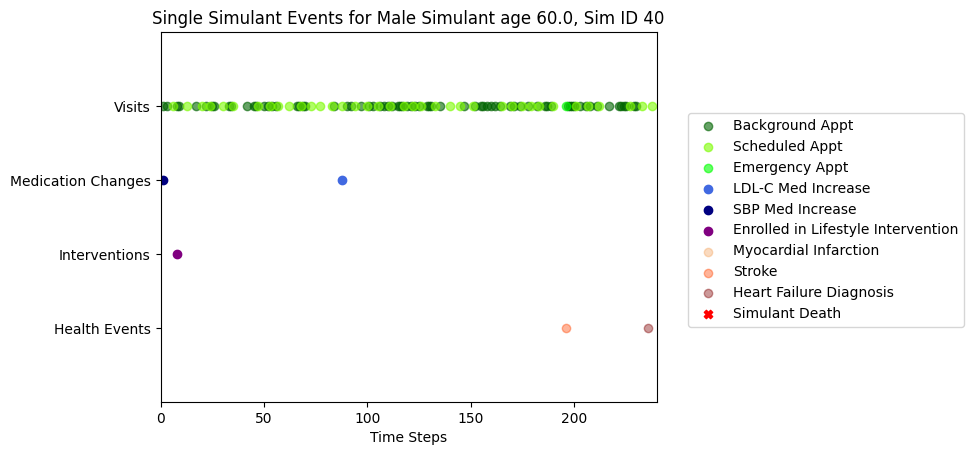

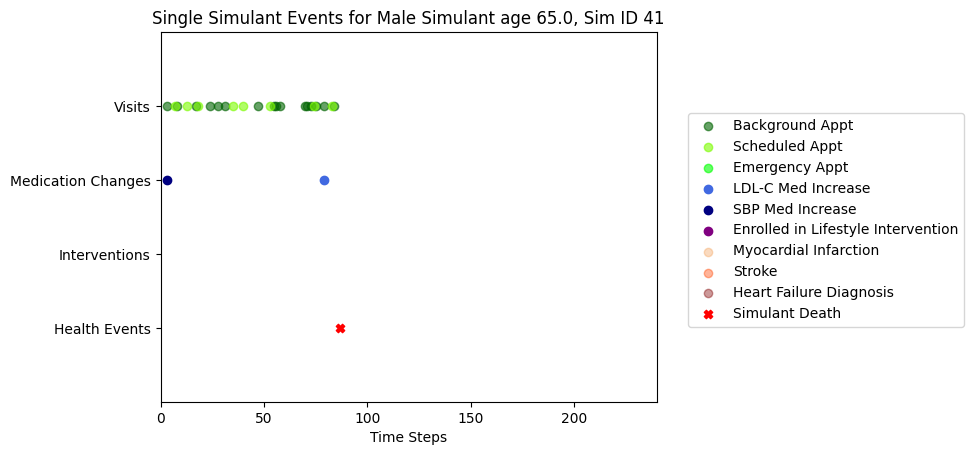

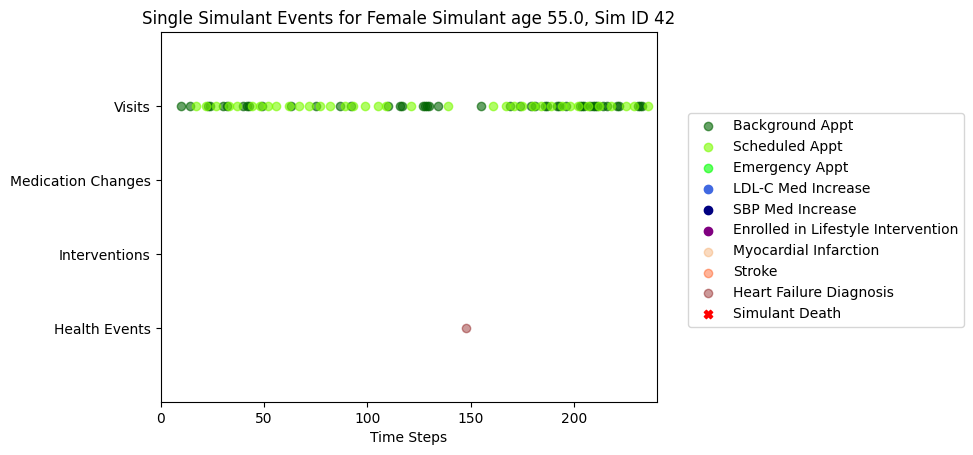

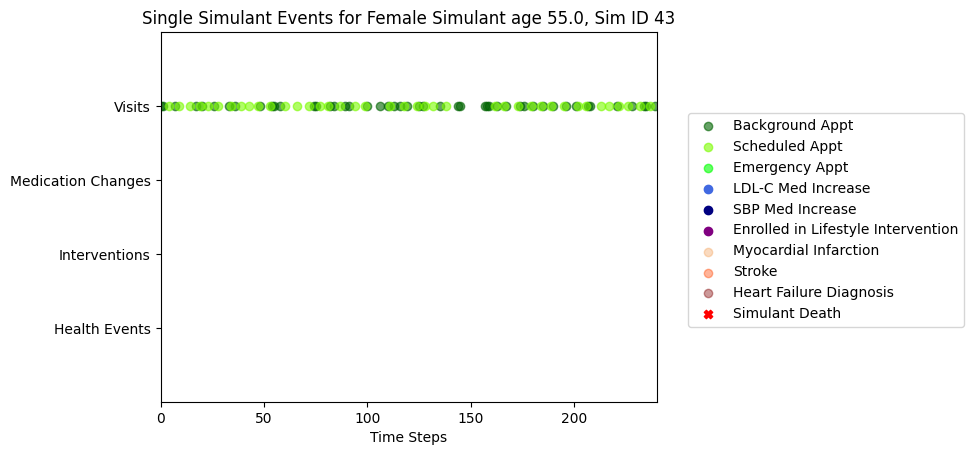

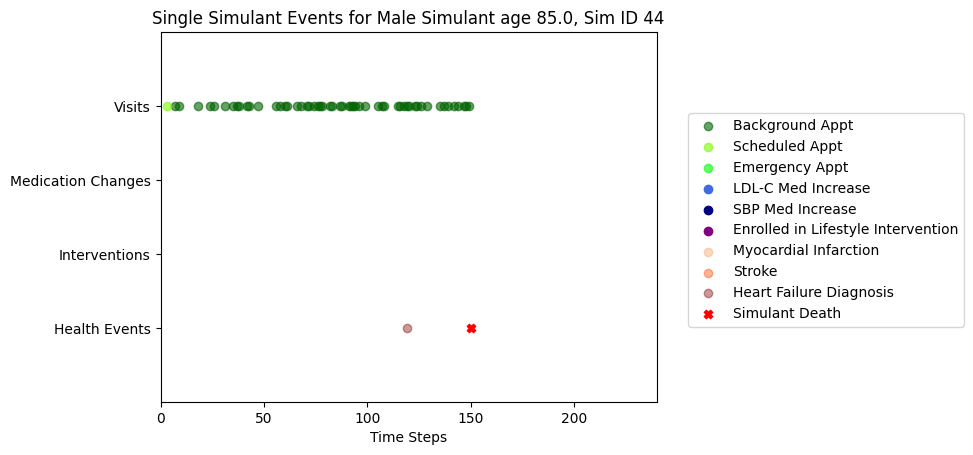

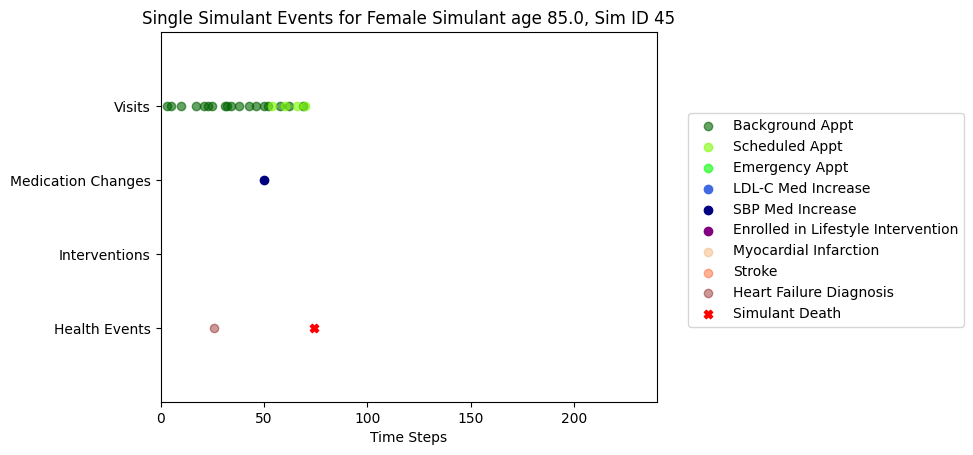

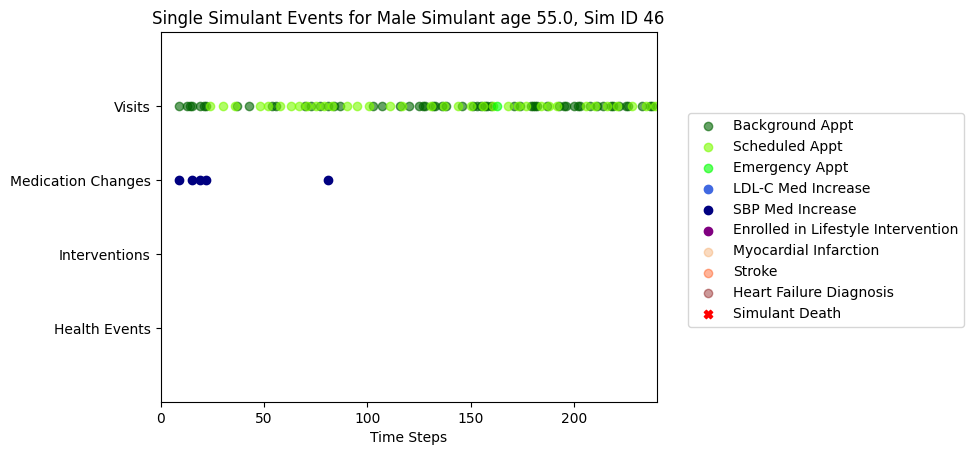

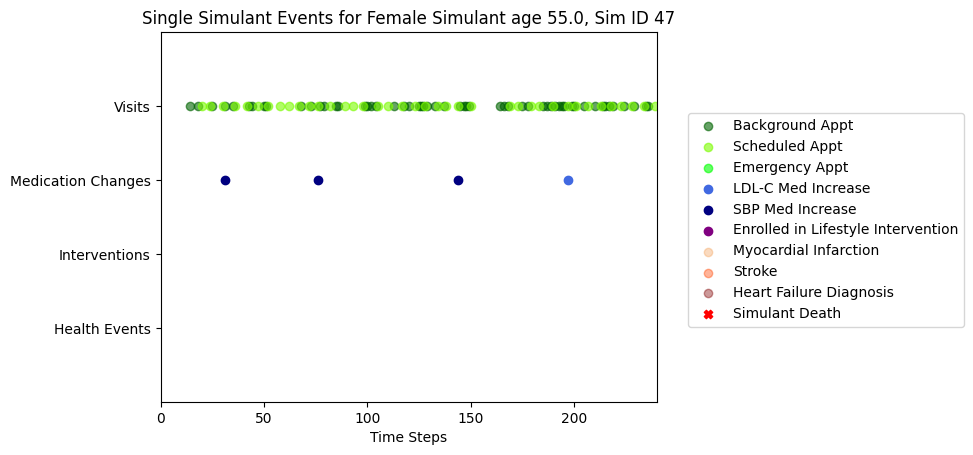

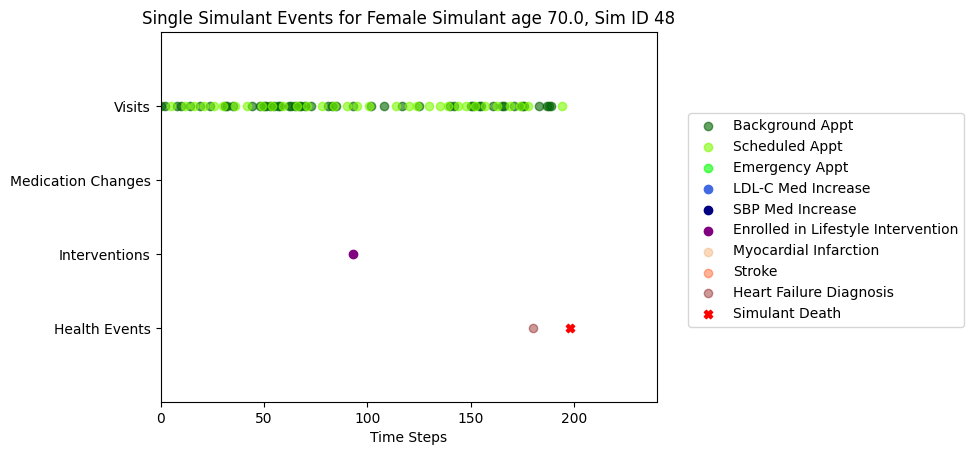

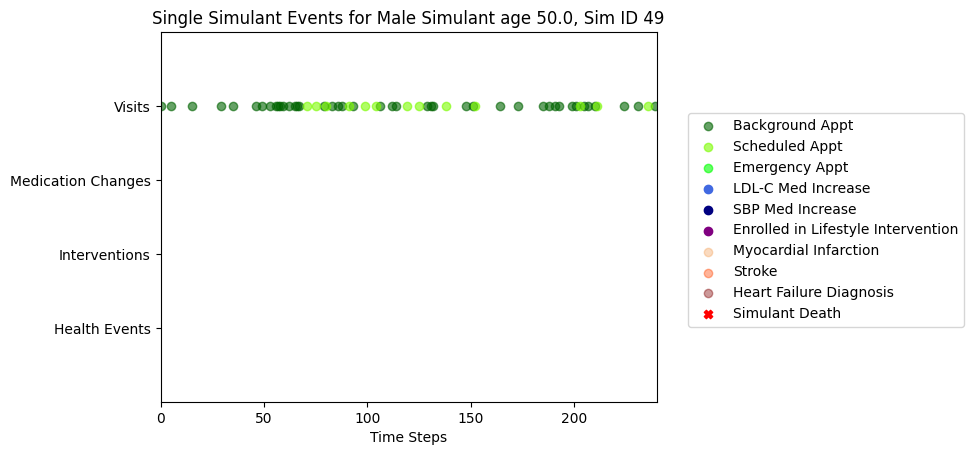

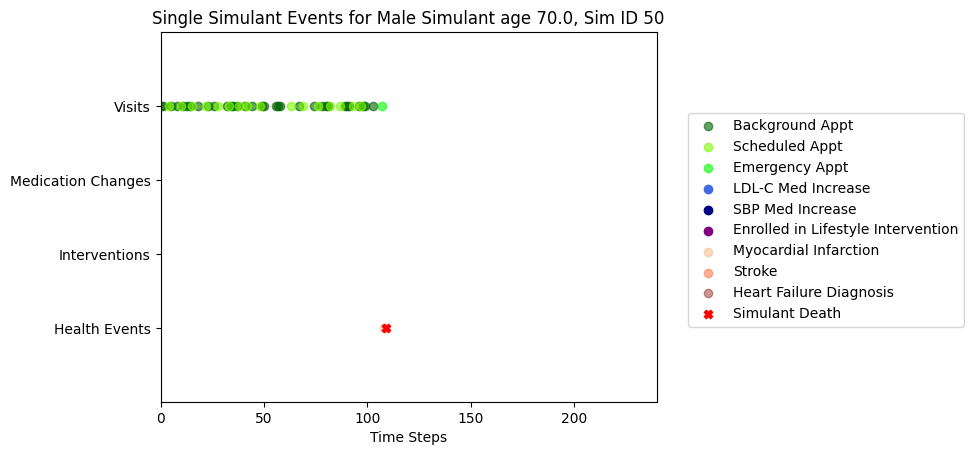

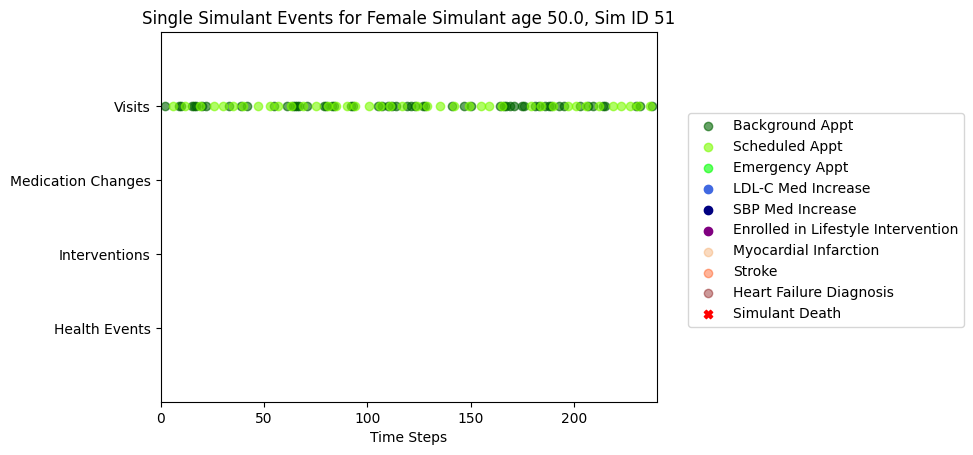

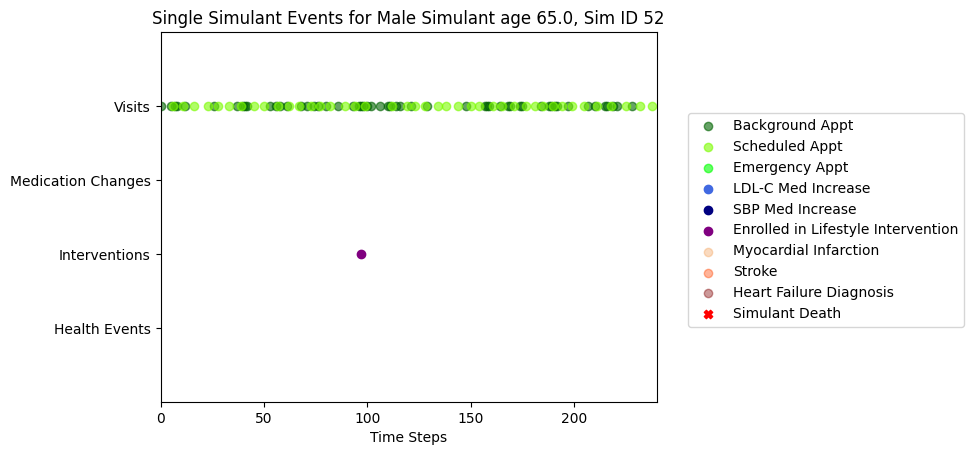

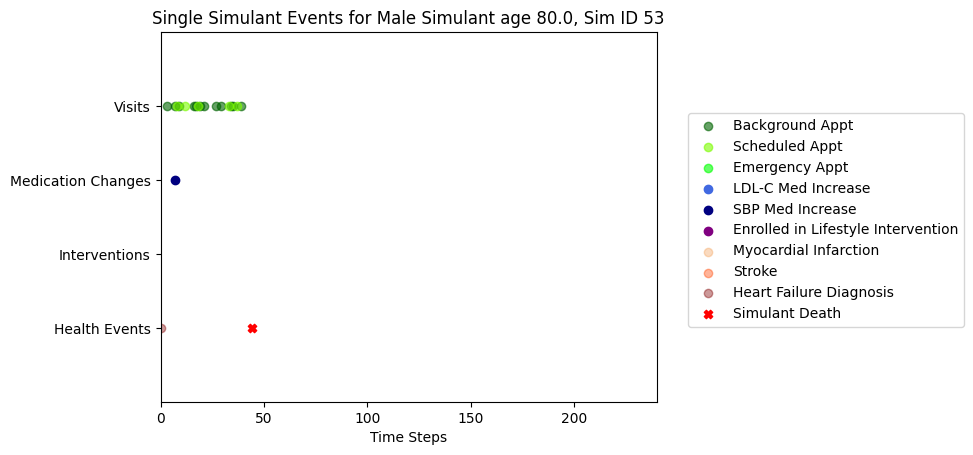

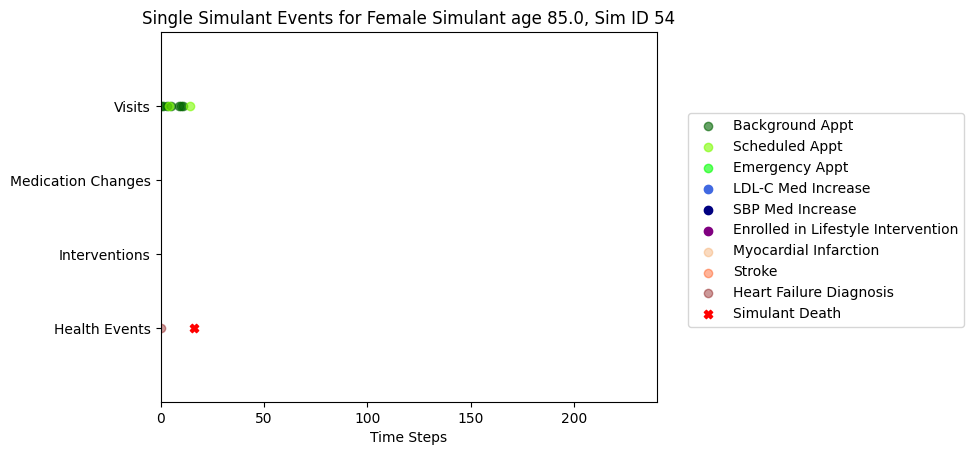

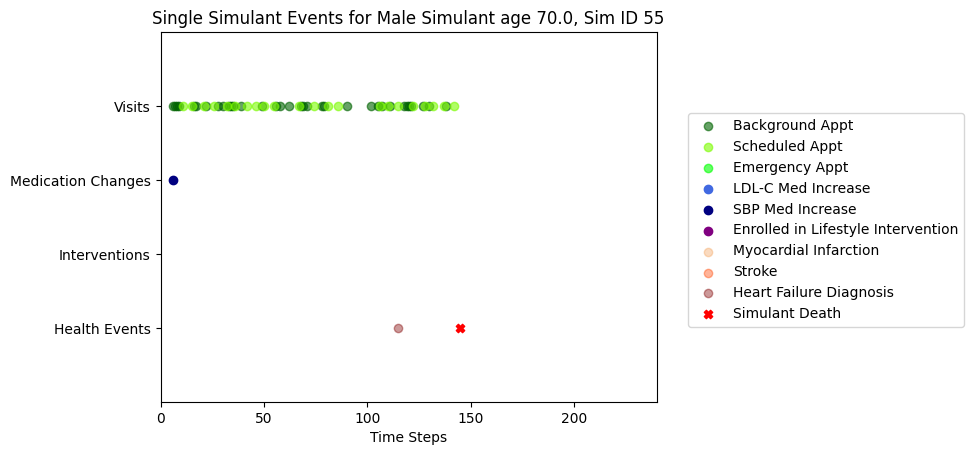

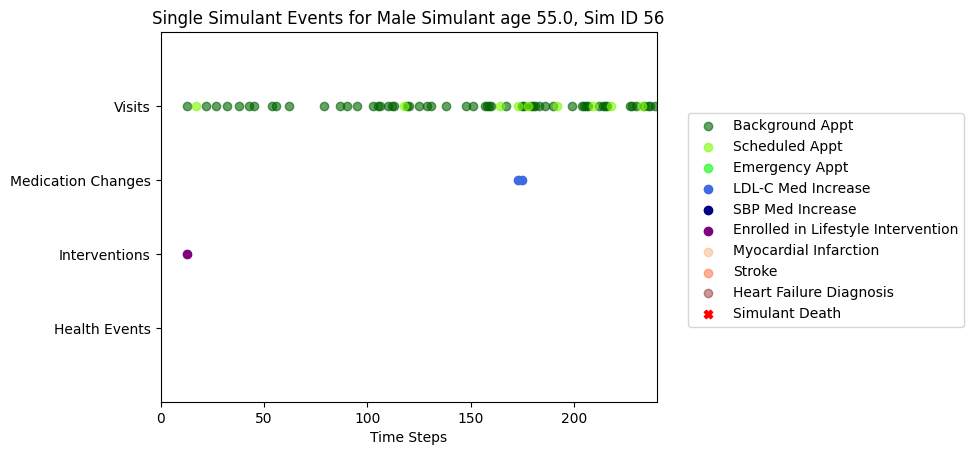

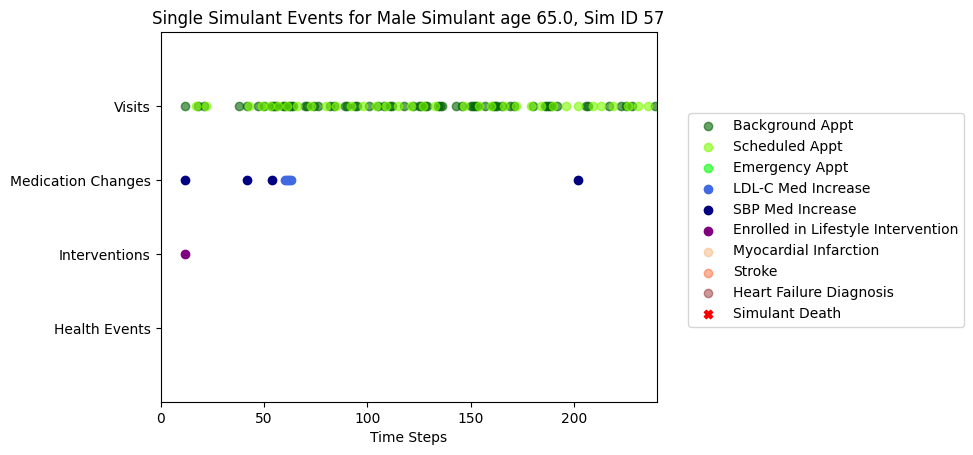

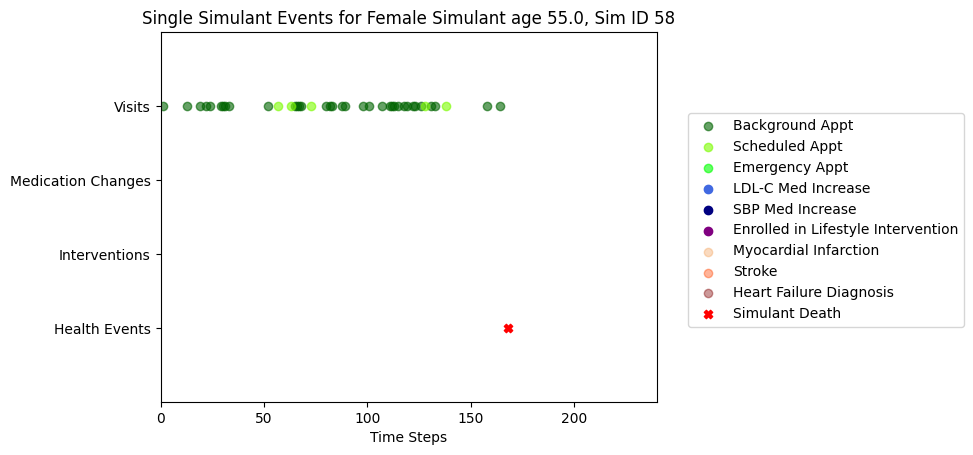

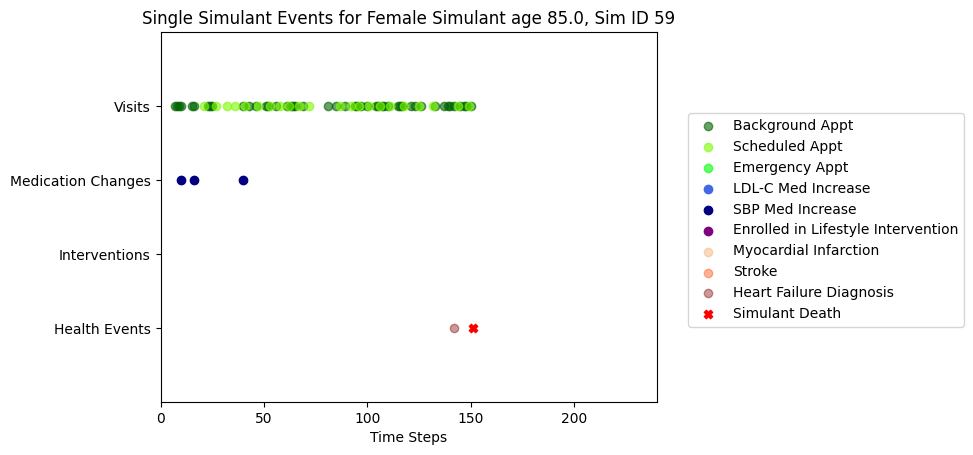

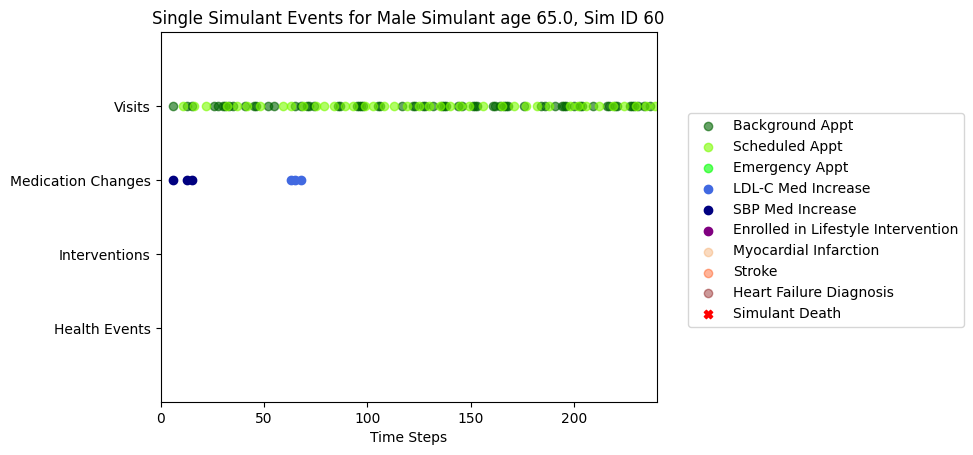

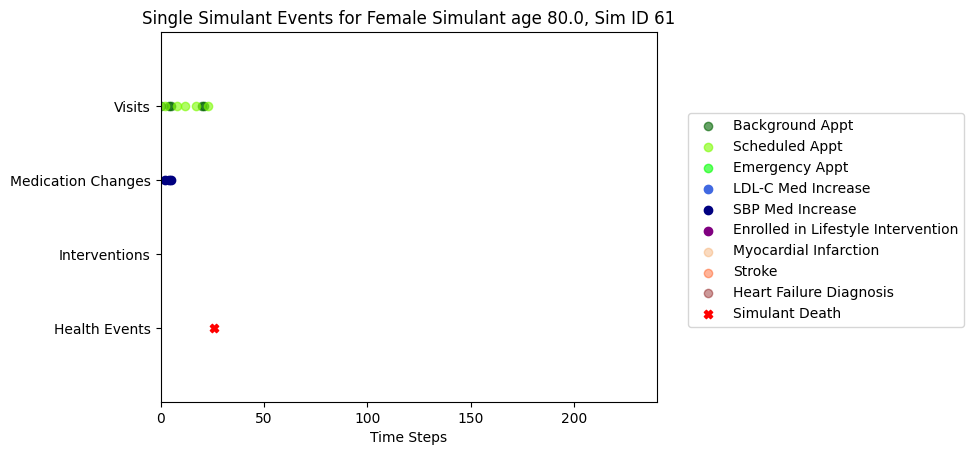

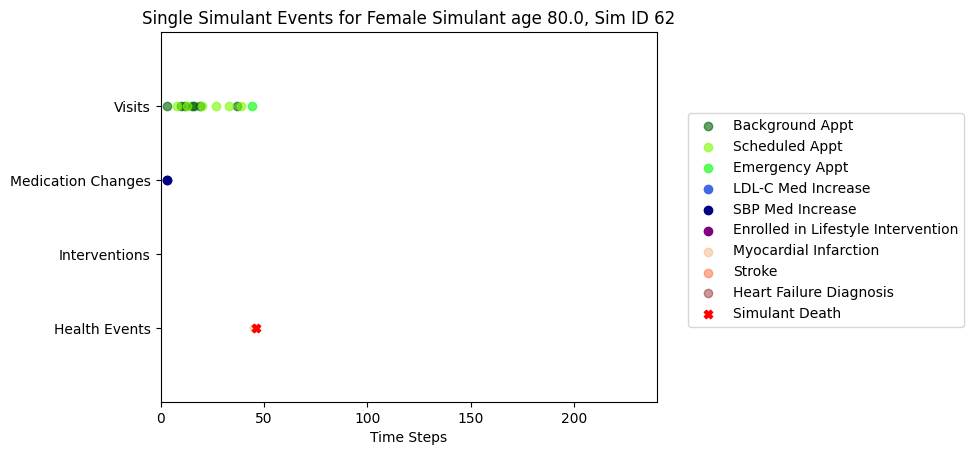

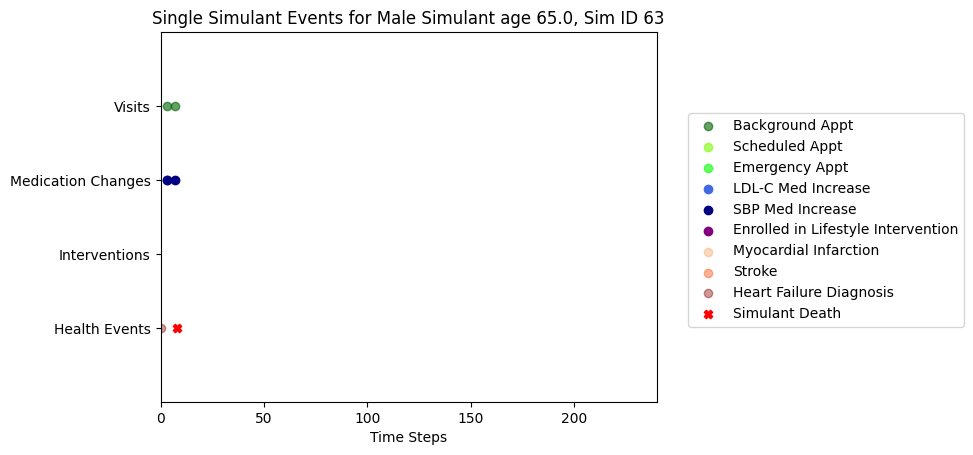

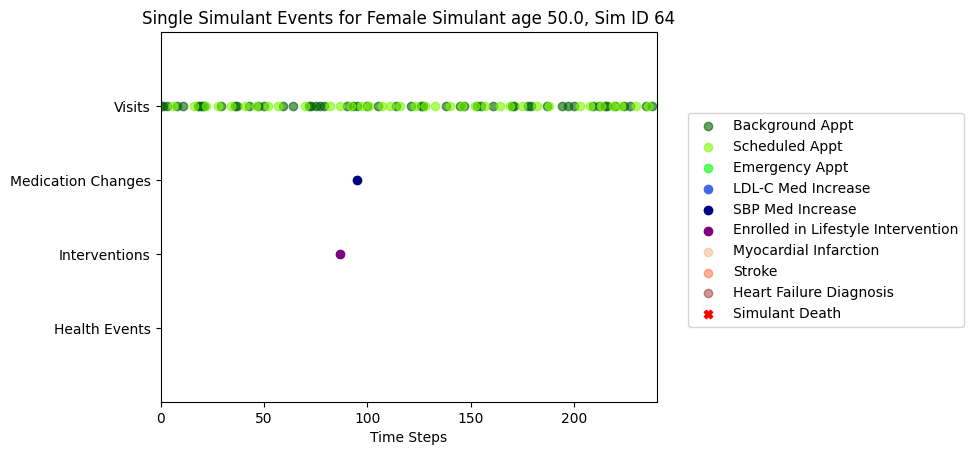

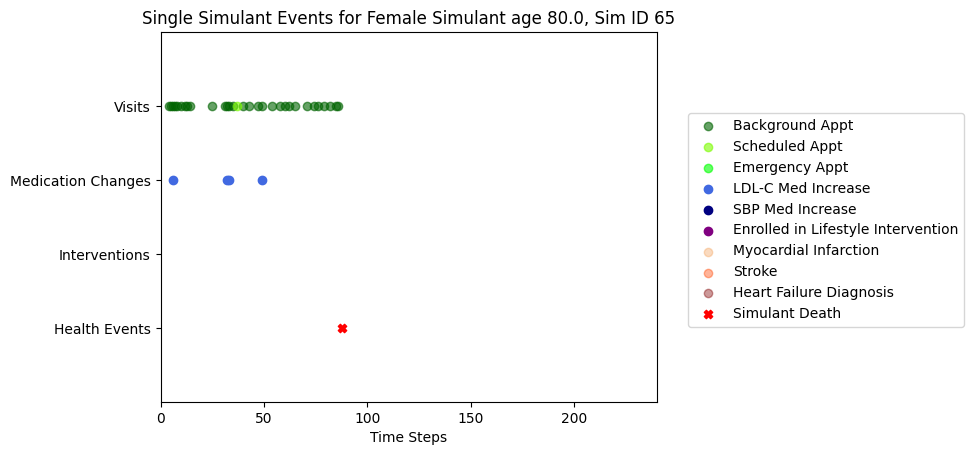

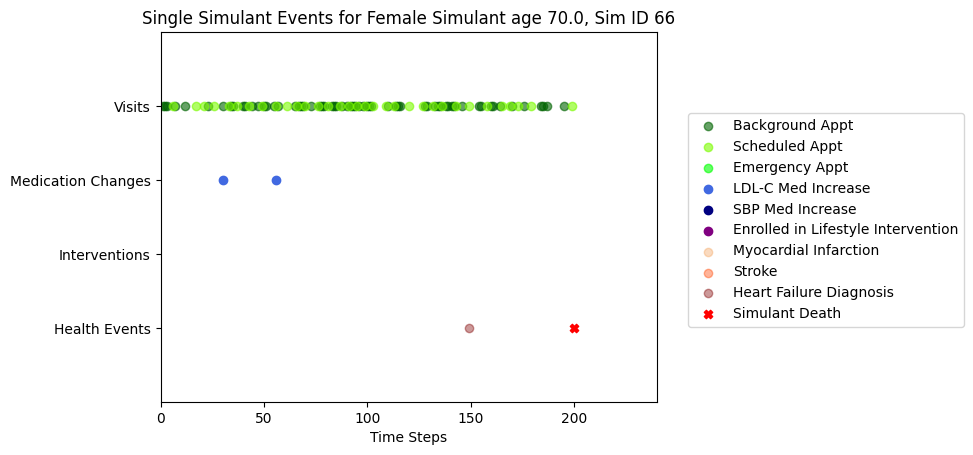

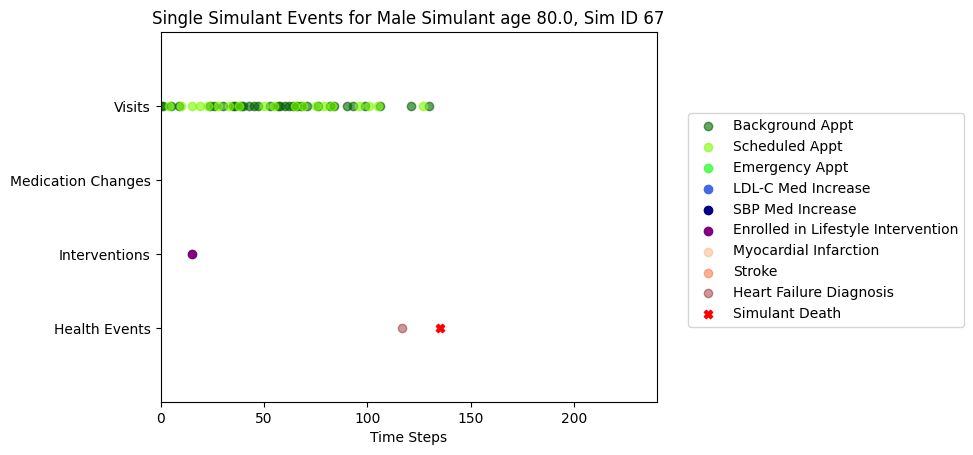

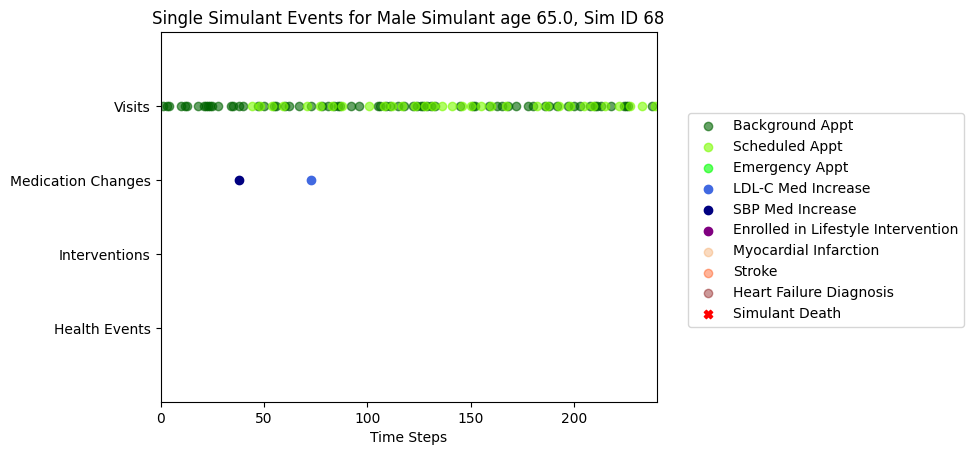

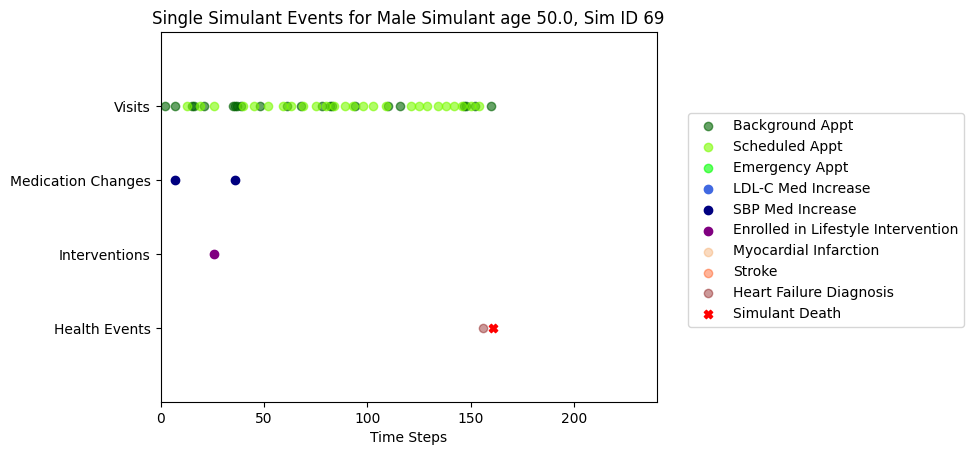

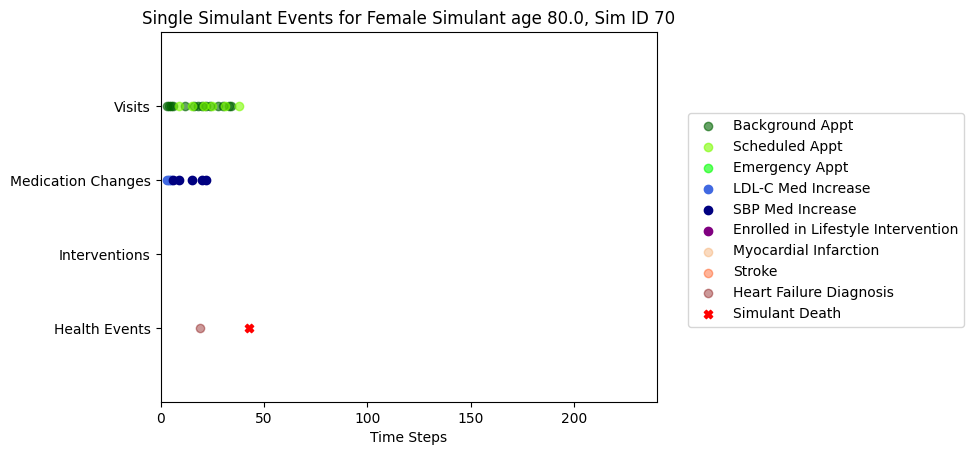

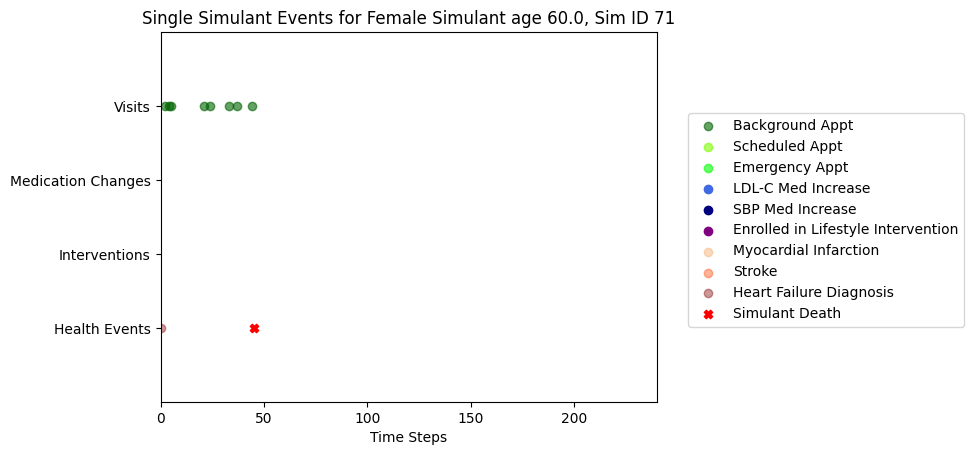

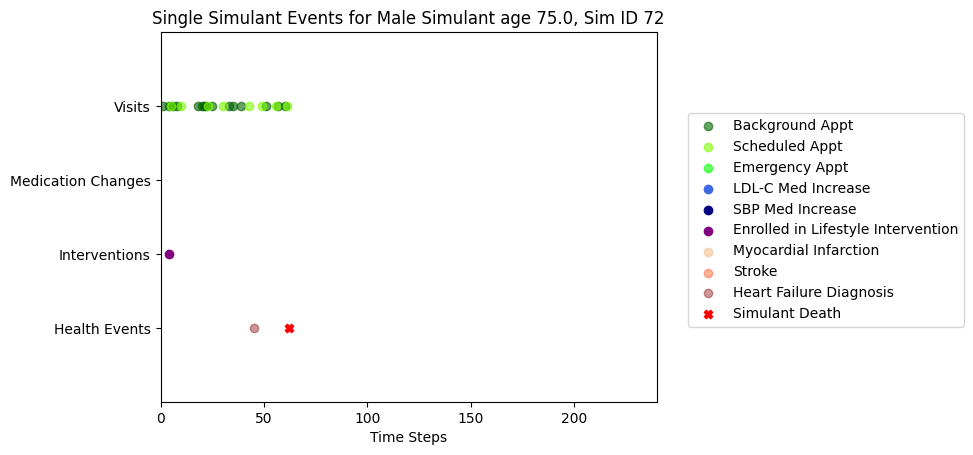

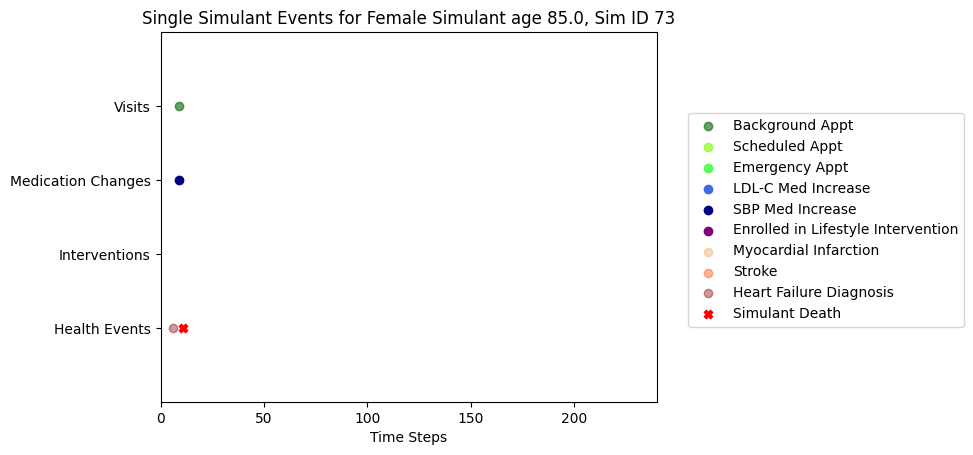

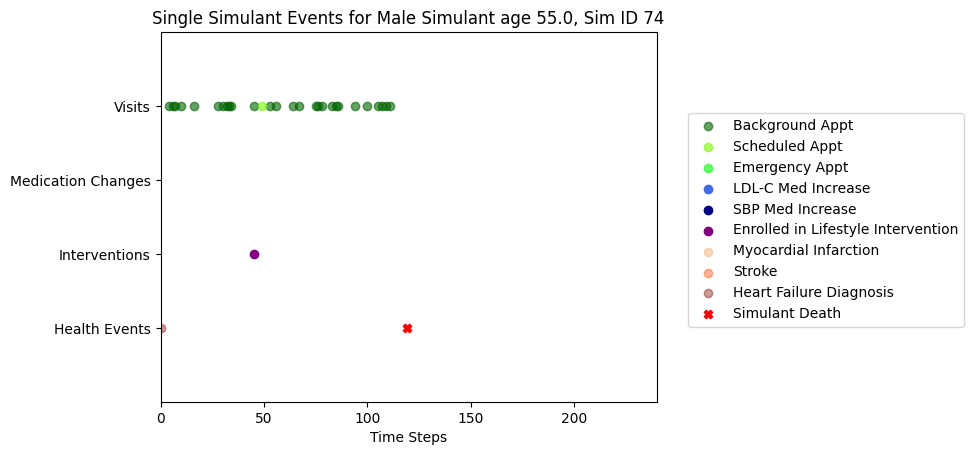

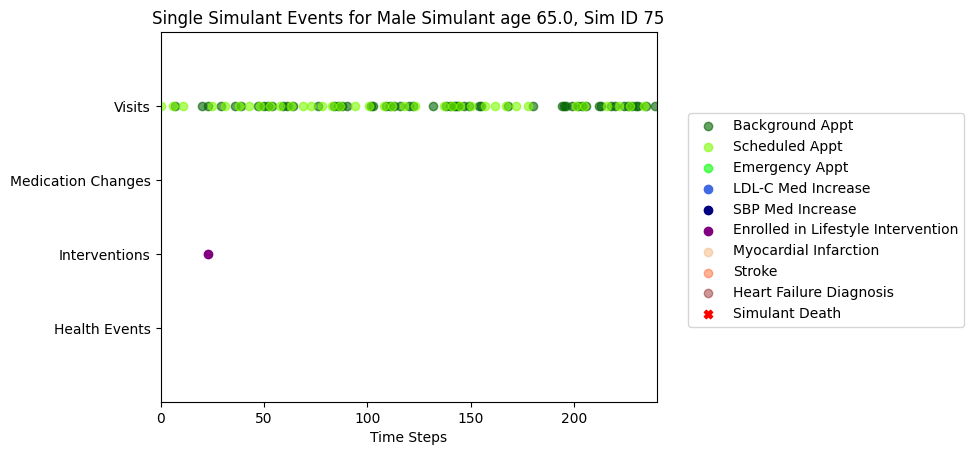

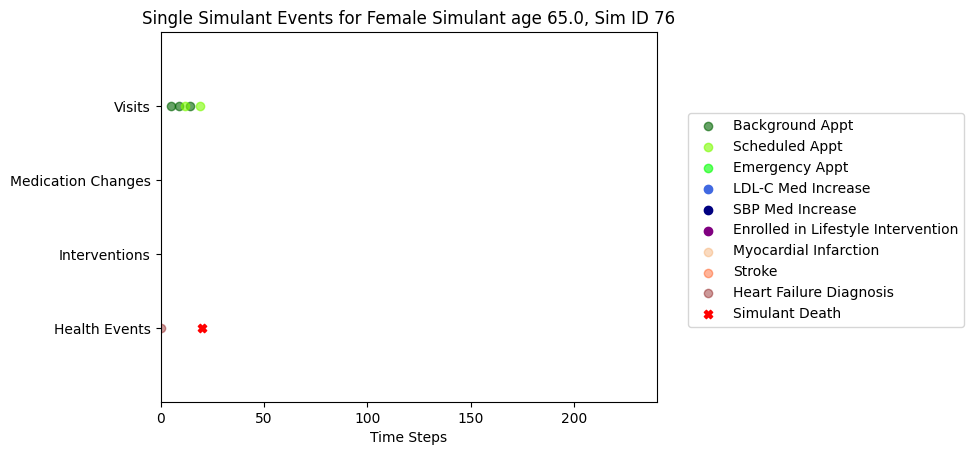

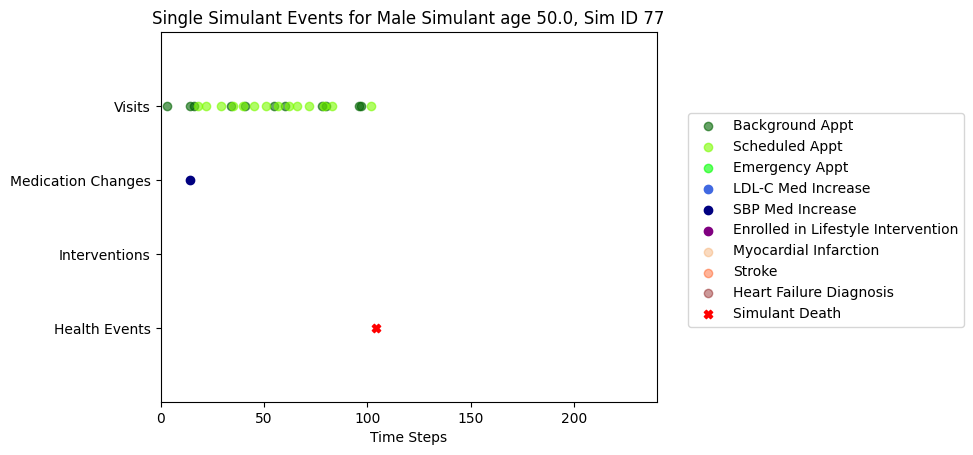

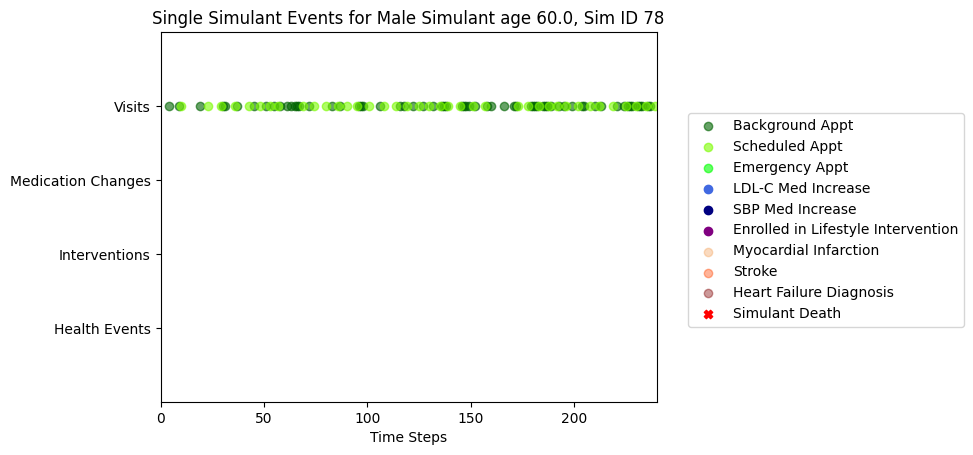

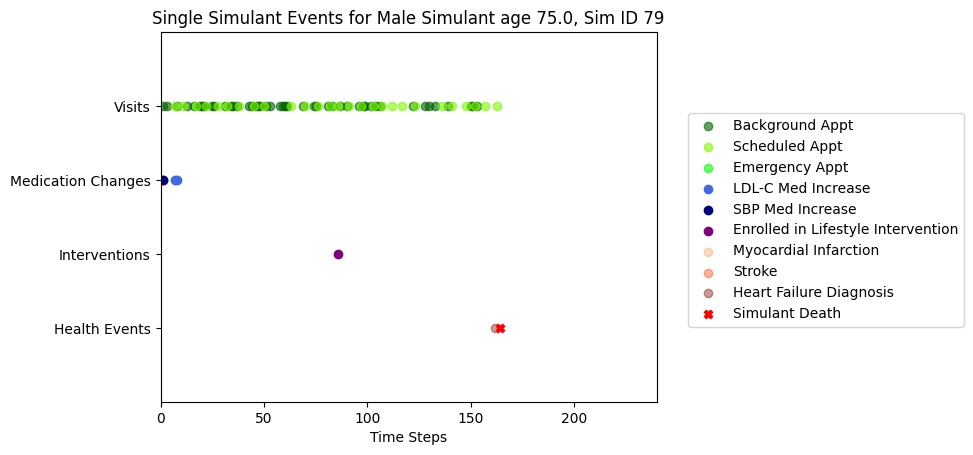

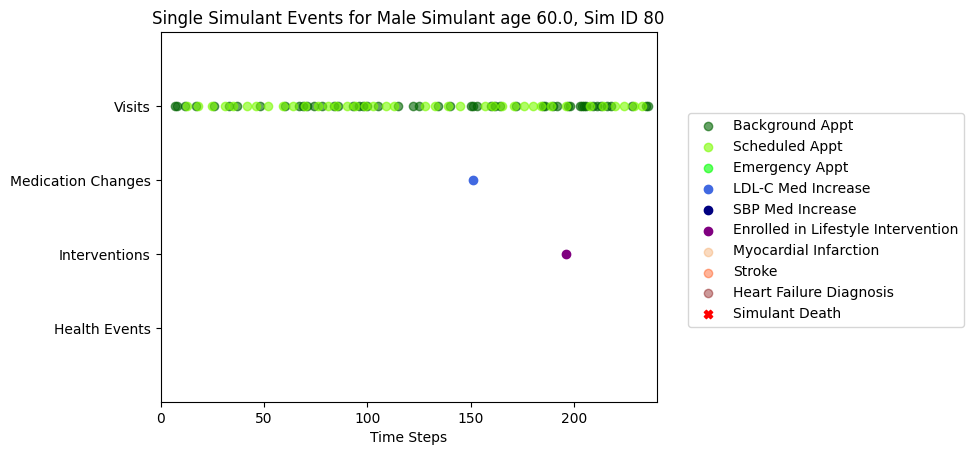

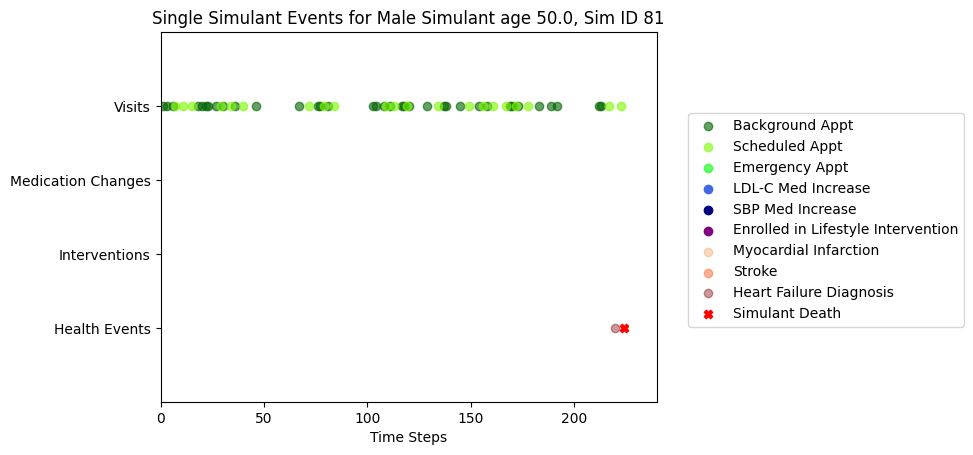

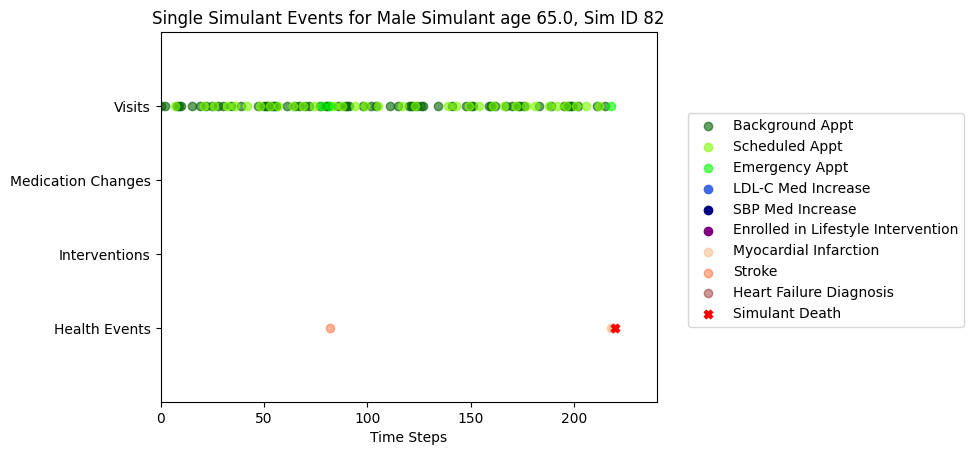

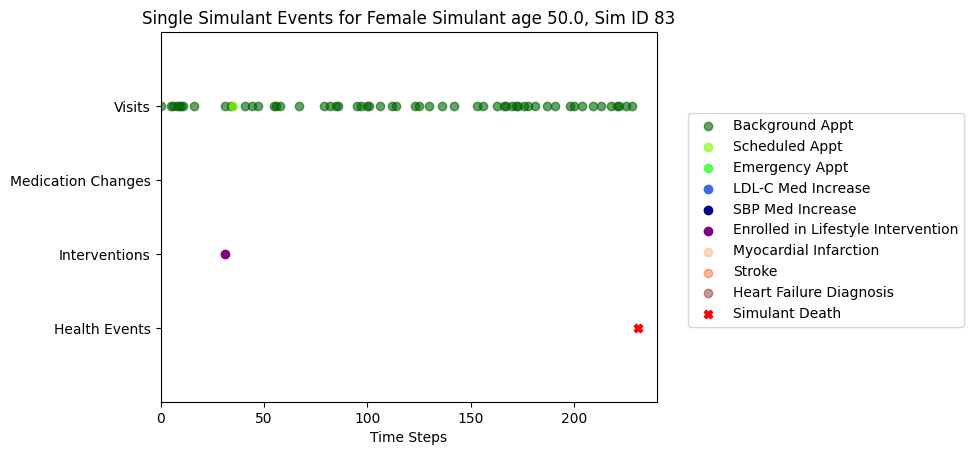

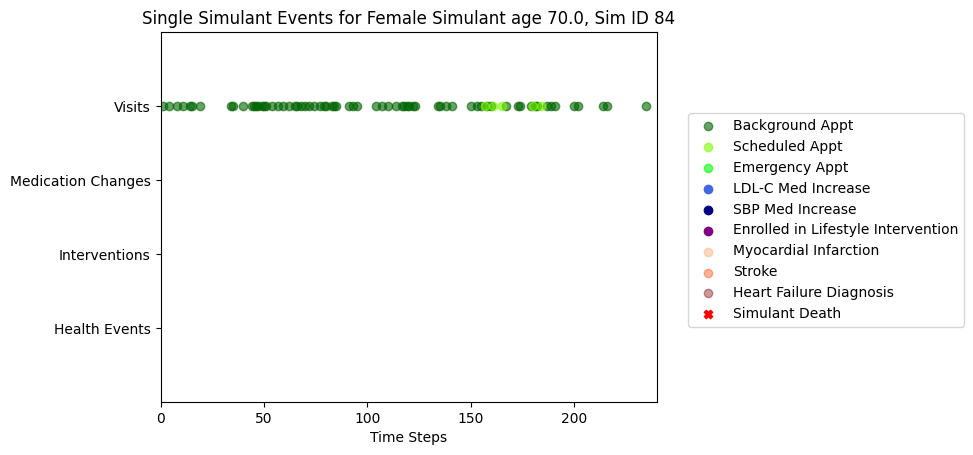

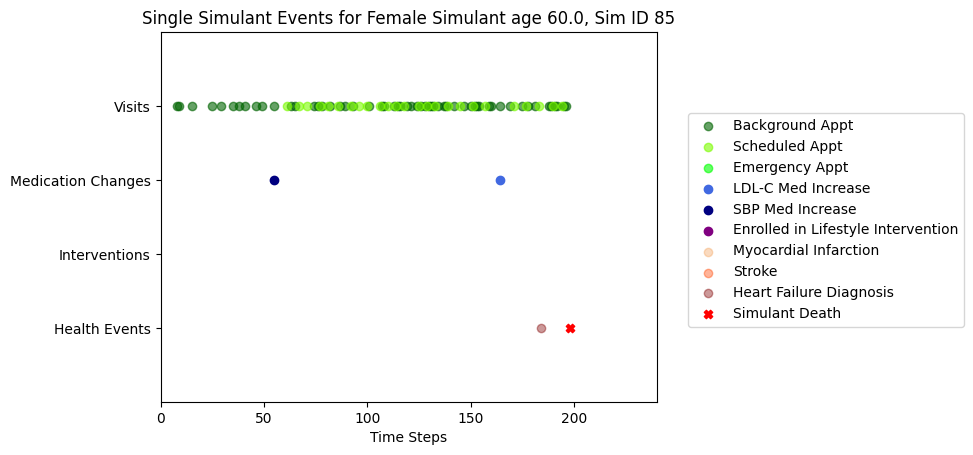

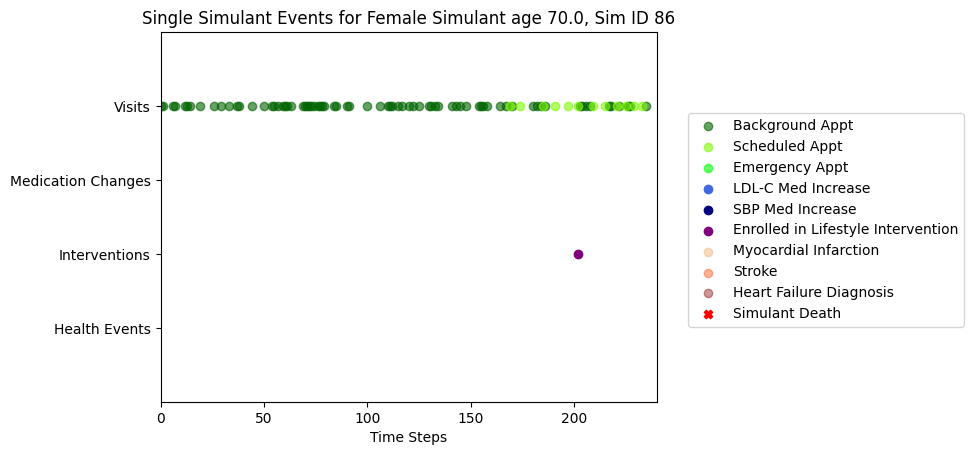

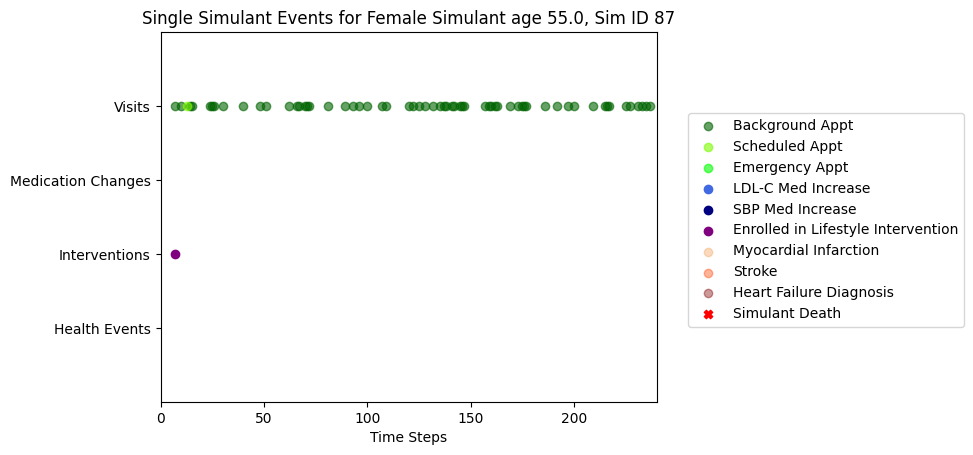

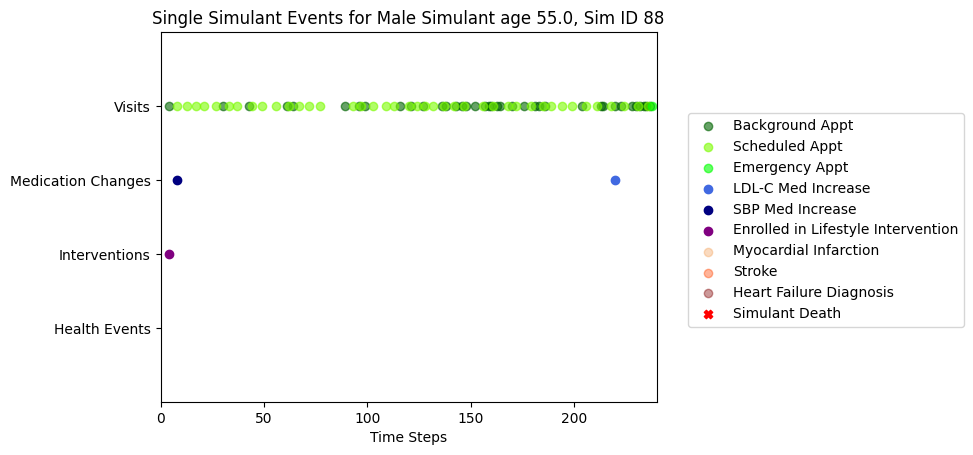

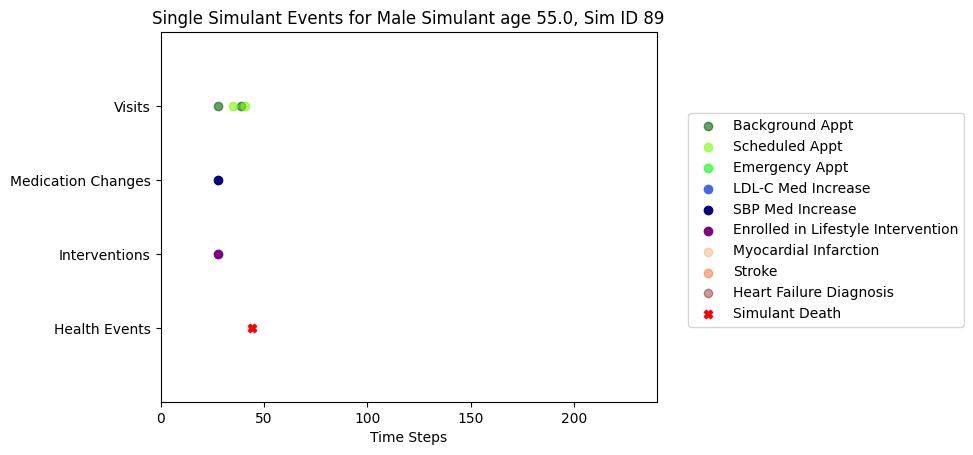

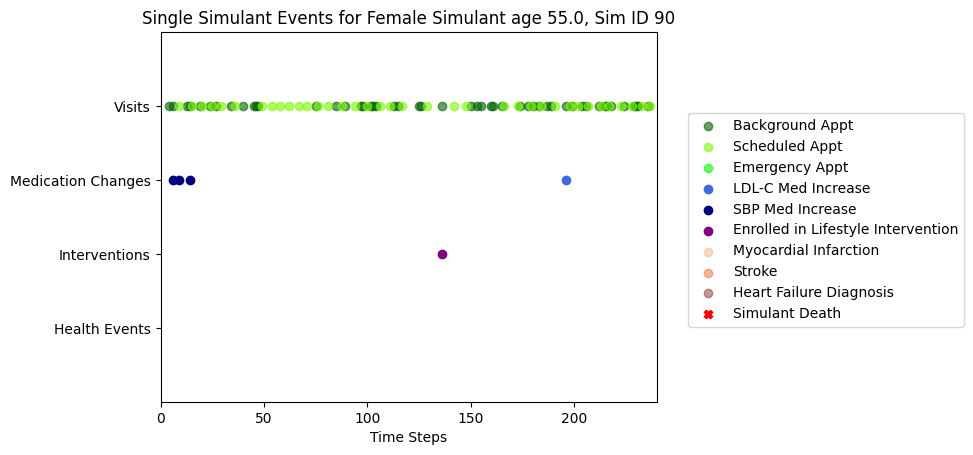

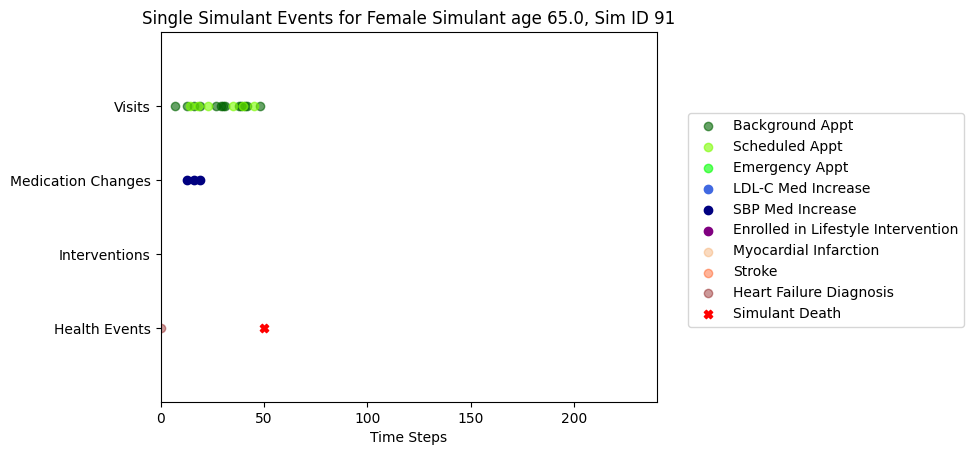

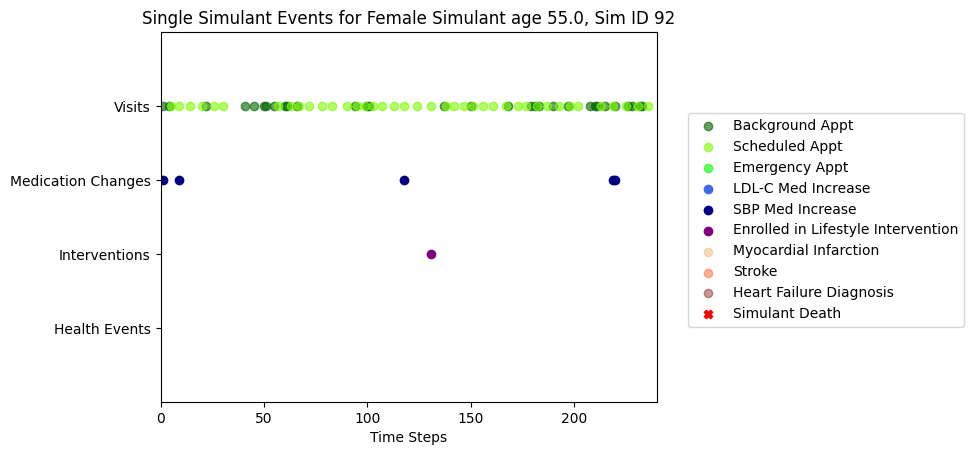

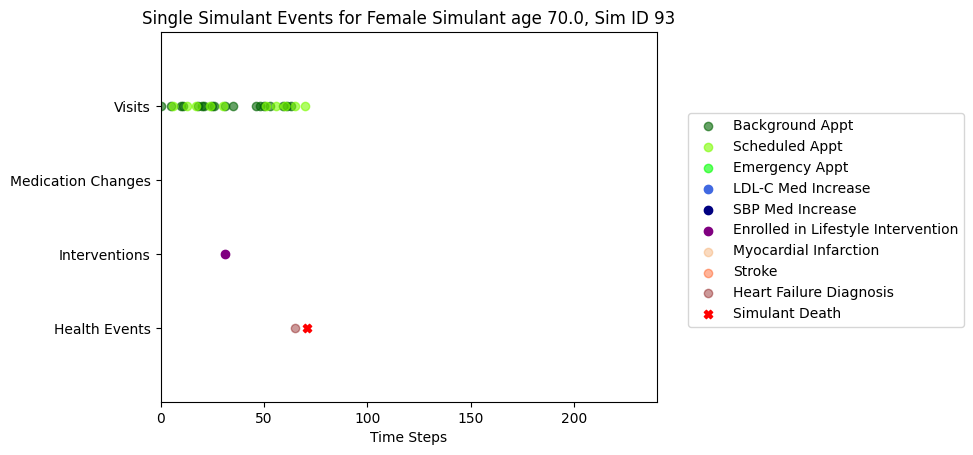

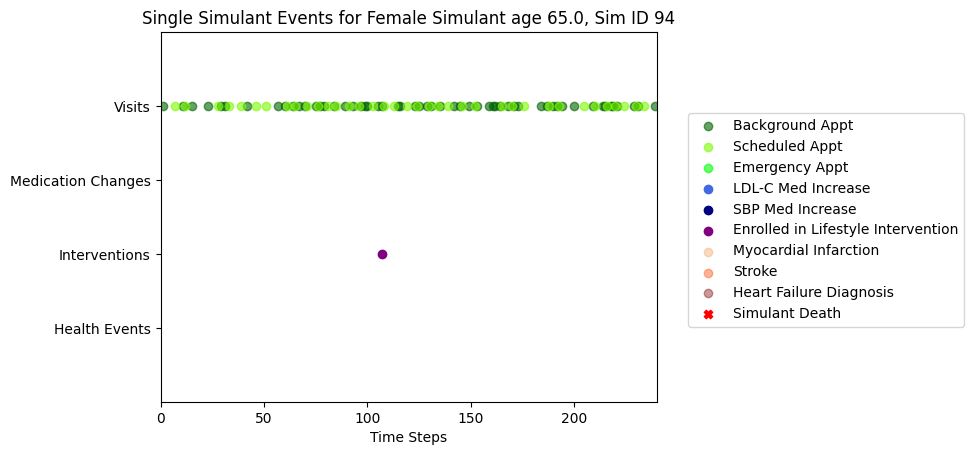

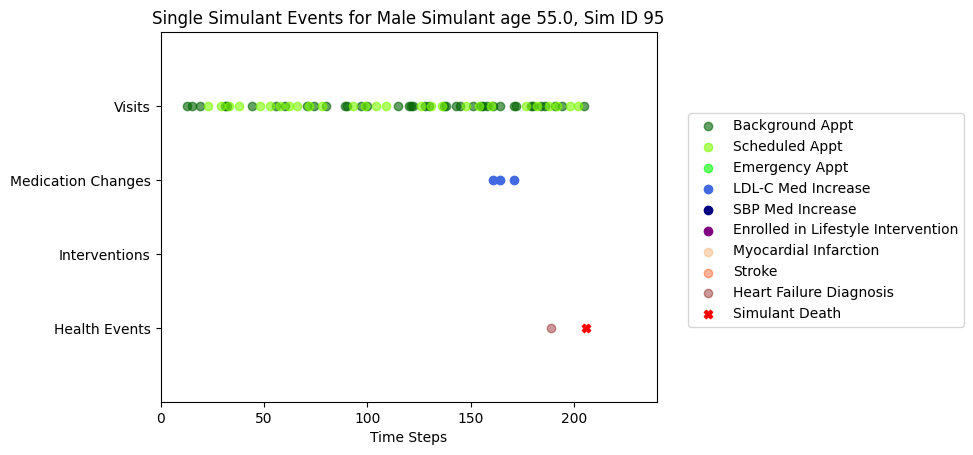

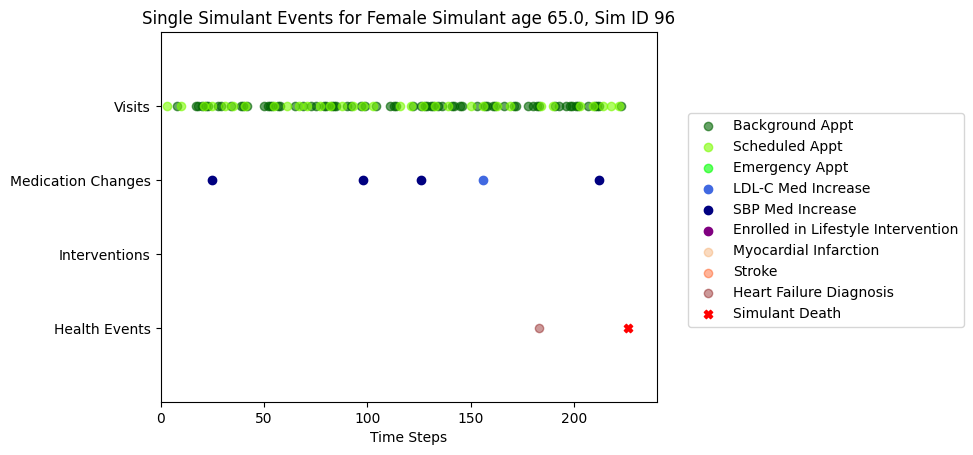

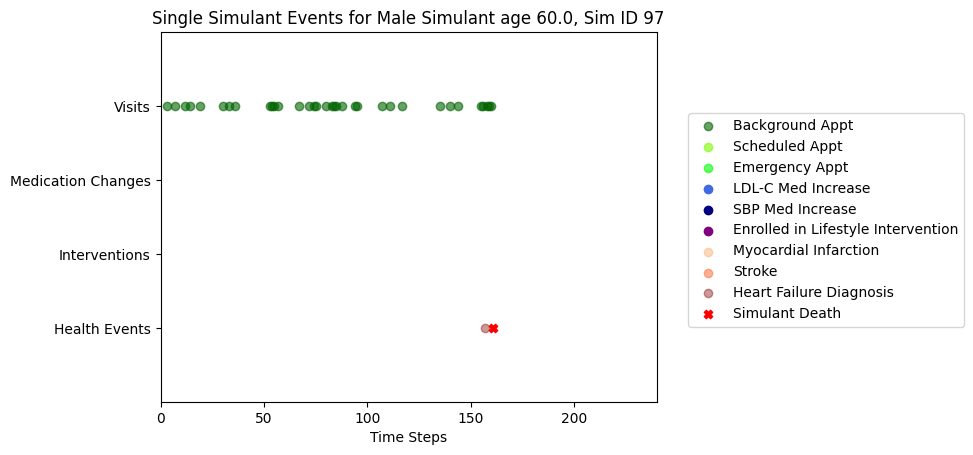

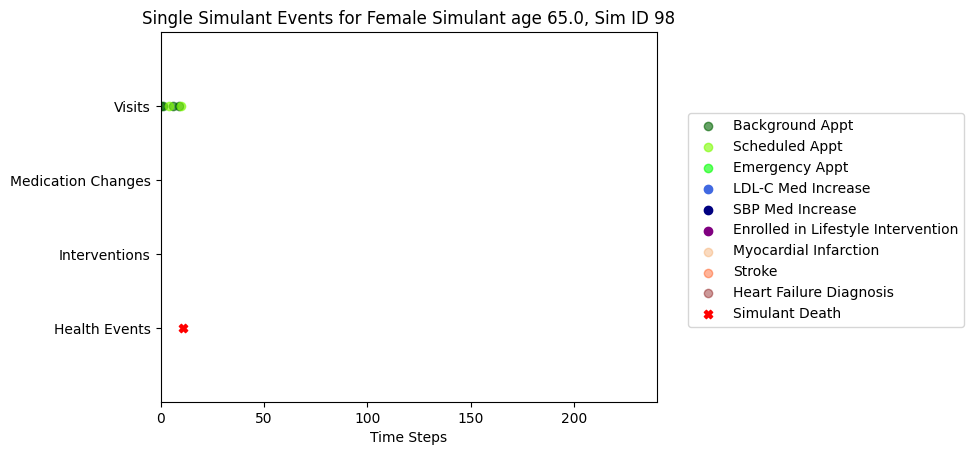

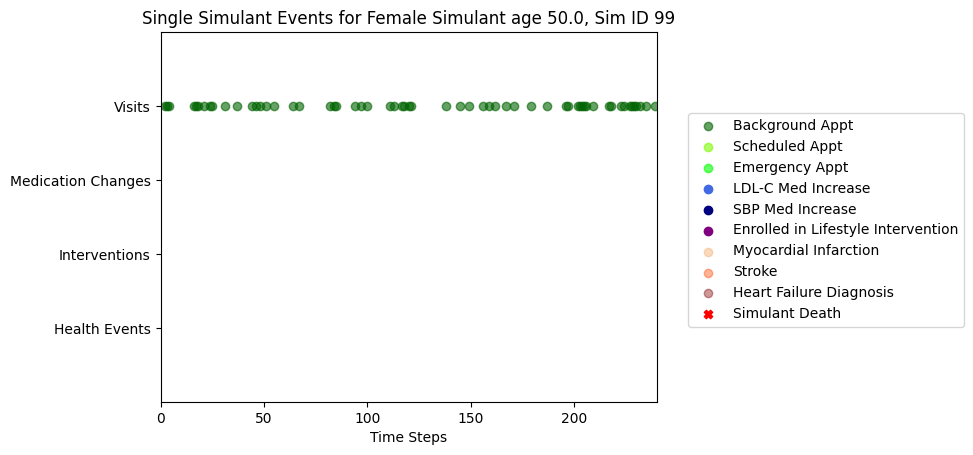

In [54]:
with PdfPages('single_sim_events_100_sims_lifestyle.pdf') as pdf:
    for sim_id in event_data.sim_id.unique():
        single_sim = event_data.loc[(event_data['sim_id']==sim_id)]
        age = single_sim.loc[single_sim.step==0].age_start.iloc[0]
        sex = single_sim.loc[single_sim.step==0].sex.iloc[0]
        died, died_y, MI, MI_y, HF, HF_y, stroke, stroke_y = health_events(single_sim)
        ldl, ldl_y, sbp, sbp_y = meds(single_sim)
        lifestyle, lifestyle_y = lifestyle_func(single_sim)
        background, background_y, scheduled, scheduled_y, emergency, emergency_y = visits(single_sim)
        y_labels = ['Visits','Medication Changes','Interventions','Health Events']
        y_ticks = [5,4,3,2]
        plt.figure()
        plt.scatter(background, background_y, c='darkgreen', label = 'Background Appt', alpha = 0.6)
        plt.scatter(scheduled, scheduled_y, c='lawngreen', label = 'Scheduled Appt', alpha = 0.6)
        plt.scatter(emergency, emergency_y, c='lime', label = 'Emergency Appt', alpha = 0.6)
        plt.scatter(ldl, ldl_y, c='royalblue', label = 'LDL-C Med Increase')
        plt.scatter(sbp, sbp_y, c='navy', label = 'SBP Med Increase')
        plt.scatter(lifestyle, lifestyle_y, c='purple', label = 'Enrolled in Lifestyle Intervention')
        plt.scatter(MI, MI_y, c='sandybrown', label = 'Myocardial Infarction', alpha = 0.4)
        plt.scatter(stroke, stroke_y, c='orangered', label = 'Stroke', alpha = 0.4)
        plt.scatter(HF, HF_y, c='maroon', label = 'Heart Failure Diagnosis', alpha = 0.4)
        plt.scatter(died, died_y, c='red', marker='X', label = 'Simulant Death')
        plt.title(f'Single Simulant Events for {sex} Simulant age {age}, Sim ID {sim_id}')
        plt.xlabel('Time Steps')
        plt.yticks(y_ticks, y_labels)
        plt.ylim(1,6)
        plt.xlim(0,240)
        plt.legend(bbox_to_anchor=(1.05, 0.8), loc='upper left')
        pdf.savefig(bbox_inches='tight')